In [1]:
import os
import sys
import asyncio
from typing import Dict, List, Any
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from difflib import SequenceMatcher

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Import project-specific modules
from models.product import Product
from services.weaviate_service import WeaviateService
from services.openai_service import OpenAIService
from services.query_processor import QueryProcessor
from config import Config

# Load configuration and initialize services
config = Config()
weaviate_service = None
openai_service = None
query_processor = None


async def initialize_services():
    global weaviate_service, openai_service, query_processor
    weaviate_service = WeaviateService()
    await weaviate_service.initialize_weaviate(config.OPENAI_API_KEY, config.WEAVIATE_URL, config.RESET_WEAVIATE)
    openai_service = OpenAIService(config.OPENAI_API_KEY, config)
    query_processor = QueryProcessor(openai_service=openai_service)


# Run initialization
await initialize_services()

INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:root: Weaviate schema is valid: True
INFO:root: Weaviate schema info: Weaviate Schema Information

Class: Product (Entries: 768)
Properties:
  - Name: name, Type: text, Description: The name of the product.
  - Name: ids, Type: text, Description: ids of the products
  - Name: manufacturer, Type: text, Description: The manufacturer of the product.
  - Name: form_factor, Type: text, Description: The form of the product.
  - Name: processor, Type: text, Description: The processor of the product.
  - Name: core_coun

===:> Initializing Weaviate


In [2]:
# Define test cases with similar queries
test_cases = [
    {
        "name": "List Single Board Computers with a processor frequency of 1.5 GHz or higher and manufactured by Broadcom",
        "queries": [
            "List Single Board Computers with a processor frequency of 1.5 GHz or higher and manufactured by Broadcom",
            "Enumerate Broadcom-made SBCs featuring processors running at 1.5 GHz or above",
            "Show Single Board Computers from Broadcom with CPU speeds of at least 1.5 GHz",
            "Provide a list of Broadcom SBCs with processors clocked at 1.5 GHz or faster",
            "Display Single Board Computers manufactured by Broadcom with CPU frequencies of 1.5 GHz and higher",
        ],
    },
    {
        "name": "What are the available Computers on Module (COM) with DDR4 memory support and comes with an Intel processor?",
        "queries": [
            "What are the available Computers on Module (COM) with DDR4 memory support and comes with an Intel processor?",
            "List COMs featuring Intel CPUs and DDR4 memory compatibility",
            "Show Computers on Module that have Intel processors and support DDR4 RAM",
            "Enumerate Intel-based COMs with DDR4 memory support",
            "Display available Computers on Module equipped with Intel CPUs and DDR4 memory capabilities",
        ],
    },
    {
        "name": "Show Devkits that include FPGA and are manufactured by Microsemi Corporation.",
        "queries": [
            "Show Devkits that include FPGA and are manufactured by Microsemi Corporation.",
            "List Microsemi Corporation's development kits featuring FPGAs",
            "Display FPGA-equipped devkits produced by Microsemi Corporation",
            "Enumerate Microsemi-made development kits that incorporate FPGAs",
            "Provide a list of Microsemi Corporation devkits with integrated FPGAs",
        ],
    },
    {
        "name": "Find all SBCs that support PCIe Gen3 interface and have more than 8 cores",
        "queries": [
            "Find all SBCs that support PCIe Gen3 interface and have more than 8 cores.",
            "List Single Board Computers with PCIe Gen3 support and over 8 processor cores",
            "Show SBCs featuring PCIe Gen3 compatibility and exceeding 8 cores",
            "Enumerate Single Board Computers with PCIe Gen3 interface and 9+ cores",
            "Display all SBCs that offer PCIe Gen3 support and have more than 8 CPU cores",
        ],
    },
    {
        "name": "Provide a list of products with ARM Cortex processors that are available in a COM Express Basic form factor.",
        "queries": [
            "Provide a list of products with ARM Cortex processors that are available in a COM Express Basic form factor.",
            "Show COM Express Basic modules featuring ARM Cortex processors",
            "Enumerate products using ARM Cortex CPUs in COM Express Basic form factor",
            "List COM Express Basic offerings equipped with ARM Cortex processors",
            "Display ARM Cortex-based products available in COM Express Basic format",
        ],
    },
    {
        "name": "Identify all hardware components manufactured by Broadcom Corporation that include ARM processors.",
        "queries": [
            "Identify all hardware components manufactured by Broadcom Corporation that include ARM processors.",
            "List Broadcom Corporation products featuring ARM processors",
            "Show hardware components from Broadcom that use ARM-based CPUs",
            "Enumerate Broadcom-made devices incorporating ARM processors",
            "Display all ARM processor-equipped hardware produced by Broadcom Corporation",
        ],
    },
    {
        "name": "Which Advantech Computer on Modules support USB 3.0 interface?",
        "queries": [
            "Which Advantech Computer on Modules support USB 3.0 interface?",
            "List Advantech COMs that offer USB 3.0 compatibility",
            "Show Computer on Modules from Advantech with USB 3.0 support",
            "Enumerate Advantech-made COMs featuring USB 3.0 interfaces",
            "Display Advantech Computer on Modules equipped with USB 3.0 ports",
        ],
    },
    {
        "name": "List all Single Board Computers with a memory capacity of 128GB or more with more than 2 USB ports.",
        "queries": [
            "List all Single Board Computers with a memory capacity of 128GB or more with more than 2 USB ports.",
            "Show SBCs featuring 128GB+ memory and 3 or more USB ports",
            "Enumerate Single Board Computers with at least 128GB memory and over 2 USB interfaces",
            "Display SBCs that have 128GB or higher memory capacity and more than two USB ports",
            "Provide a list of Single Board Computers with 128GB+ RAM and 3+ USB connections",
        ],
    },
    {
        "name": "What are the available NXP powered Computer on Module products that include SATA 3.0 interface?",
        "queries": [
            "What are the available NXP powered Computer on Module products that include SATA 3.0 interface?",
            "List COMs with NXP processors featuring SATA 3.0 support",
            "Show NXP-based Computer on Modules that offer SATA 3.0 connectivity",
            "Enumerate NXP-powered COMs equipped with SATA 3.0 interfaces",
            "Display Computer on Module products using NXP chips and including SATA 3.0 ports",
        ],
    },
    {
        "name": "Find Single Board Computers with a form factor smaller than 100mm x 100mm and RAM more 256 MB",
        "queries": [
            "Find Single Board Computers with a form factor smaller than 100mm x 100mm and RAM more 256 MB",
            "List SBCs smaller than 100x100mm with over 256MB of RAM",
            "Show compact Single Board Computers (sub-100x100mm) featuring more than 256MB memory",
            "Enumerate SBCs with form factors under 100mm x 100mm and RAM exceeding 256MB",
            "Display Single Board Computers smaller than 100x100mm that have more than 256MB of RAM",
        ],
    },
    {
        "name": "List all devices that support voltage ranges from 1.2V to 3.3V.",
        "queries": [
            "List all devices that support voltage ranges from 1.2V to 3.3V.",
            "Show hardware components compatible with 1.2V to 3.3V voltage range",
            "Enumerate devices operating within 1.2V to 3.3V voltage specifications",
            "Display all products supporting voltage levels between 1.2V and 3.3V",
            "Provide a list of components functioning in the 1.2V to 3.3V voltage range",
        ],
    },
    {
        "name": "Show products that include an Intel Xeon Processor D and support Embedded Software API.",
        "queries": [
            "Show products that include an Intel Xeon Processor D and support Embedded Software API.",
            "List devices featuring Intel Xeon D CPUs with Embedded Software API compatibility",
            "Enumerate products using Intel Xeon Processor D and offering Embedded Software API support",
            "Display hardware with Intel Xeon D chips that are compatible with Embedded Software API",
            "Provide a list of Intel Xeon D-based products supporting Embedded Software API",
        ],
    },
    {
        "name": "Which products offer a high-performance FPGA feature and are suitable for embedded development?",
        "queries": [
            "Which products offer a high-performance FPGA feature and are suitable for embedded development?",
            "List high-performance FPGA products designed for embedded systems",
            "Show devices with powerful FPGAs tailored for embedded development",
            "Enumerate high-end FPGA offerings suitable for embedded applications",
            "Display products combining high-performance FPGAs with embedded development capabilities",
        ],
    },
    {
        "name": "Provide a list of Single Board Computers that can operate at a frequency up to 2.7 GHz with MiniITX form factor.",
        "queries": [
            "Provide a list of Single Board Computers that can operate at a frequency up to 2.7 GHz with MiniITX form factor.",
            "Show MiniITX SBCs capable of running at frequencies up to 2.7 GHz",
            "Enumerate Single Board Computers in MiniITX form factor with max 2.7 GHz clock speed",
            "List MiniITX-format SBCs that can reach 2.7 GHz operating frequency",
            "Display Single Board Computers with MiniITX form factor and up to 2.7 GHz processor speed",
        ],
    },
    {
        "name": "What components are available with embedded nonvolatile flash memory (eNVM)?",
        "queries": [
            "What components are available with embedded nonvolatile flash memory (eNVM)?",
            "List hardware featuring built-in nonvolatile flash memory (eNVM)",
            "Show products that include embedded nonvolatile flash memory",
            "Enumerate devices equipped with integrated eNVM",
            "Display components offering embedded nonvolatile flash memory capabilities",
        ],
    },
    {
        "name": 'Identify all products with a "Customizable System-on-Chip (cSoC)" type with ARM Cortex processor.',
        "queries": [
            'Identify all products with a "Customizable System-on-Chip (cSoC)" type with ARM Cortex processor.',
            "List ARM Cortex-based Customizable System-on-Chip (cSoC) offerings",
            "Show cSoC products featuring ARM Cortex processors",
            "Enumerate Customizable System-on-Chip devices with ARM Cortex CPUs",
            "Display all ARM Cortex-powered cSoC solutions",
        ],
    },
    {
        "name": "Top 5 Single Board Computers products that support dual Gigabit Ethernet and SATA.",
        "queries": [
            "Top 5 Single Board Computers products that support dual Gigabit Ethernet and SATA.",
            "List best 5 SBCs featuring both dual Gigabit Ethernet and SATA interfaces",
            "Show top 5 Single Board Computers with dual GbE and SATA support",
            "Enumerate 5 leading SBCs offering dual Gigabit Ethernet and SATA connectivity",
            "Display 5 premium Single Board Computers equipped with dual GbE and SATA",
        ],
    },
    {
        "name": "Which products offer up to 16 cores and 2.3 GHz frequency in their processors?",
        "queries": [
            "Which products offer up to 16 cores and 2.3 GHz frequency in their processors?",
            "List devices featuring processors with up to 16 cores and 2.3 GHz clock speed",
            "Show products with CPUs offering maximum 16 cores and 2.3 GHz frequency",
            "Enumerate hardware using processors that have up to 16 cores and 2.3 GHz speed",
            "Display items with processors supporting up to 16 cores and 2.3 GHz clock rate",
        ],
    },
    {
        "name": "Find Kontron products that include both ECC and non-ECC memory options.",
        "queries": [
            "Find Kontron products that include both ECC and non-ECC memory options.",
            "List Kontron devices supporting both ECC and non-ECC RAM",
            "Show Kontron hardware with ECC and non-ECC memory compatibility",
            "Enumerate Kontron offerings featuring both ECC and non-ECC memory support",
            "Display Kontron products that provide ECC and non-ECC memory choices",
        ],
    },
    {
        "name": "List all hardware platforms with on-chip frame memory and supports a TFT-LCD controller.",
        "queries": [
            "List all hardware platforms with on-chip frame memory and supports a TFT-LCD controller.",
            "Show devices featuring on-chip frame memory and TFT-LCD controller support",
            "Enumerate platforms that include on-chip frame memory and TFT-LCD controller capabilities",
            "Display hardware solutions with integrated frame memory and TFT-LCD controller functionality",
            "Provide a list of products combining on-chip frame memory with TFT-LCD controller support",
        ],
    },
    {
        "name": "Provide a list of Single Board Computers manufactured by Advantech that include USB 3.0 support.",
        "queries": [
            "Provide a list of Single Board Computers manufactured by Advantech that include USB 3.0 support.",
            "Show Advantech-made SBCs featuring USB 3.0 interfaces",
            "Enumerate Single Board Computers from Advantech with USB 3.0 compatibility",
            "List Advantech SBC products that offer USB 3.0 support",
            "Display Advantech-manufactured Single Board Computers equipped with USB 3.0 ports",
        ],
    },
    {
        "name": "Which devices support Intel Hyper-Threading Technology with mATX form factor?",
        "queries": [
            "Which devices support Intel Hyper-Threading Technology with mATX form factor?",
            "List mATX form factor products featuring Intel Hyper-Threading Technology",
            "Show hardware in mATX format that includes Intel Hyper-Threading support",
            "Enumerate mATX devices compatible with Intel Hyper-Threading Technology",
            "Display mATX form factor items offering Intel Hyper-Threading capabilities",
        ],
    },
    {
        "name": "Identify products that include programmable analog components and eNVM.",
        "queries": [
            "Identify products that include programmable analog components and eNVM.",
            "List devices featuring both programmable analog elements and embedded nonvolatile memory",
            "Show hardware solutions combining programmable analog capabilities with eNVM",
            "Enumerate products that offer programmable analog components alongside eNVM",
            "Display items integrating programmable analog features and embedded nonvolatile memory",
        ],
    },
    {
        "name": "What are the available hardware platforms with built-in Intel Turbo Boost Technology and Hyper-Threading Technology?",
        "queries": [
            "What are the available hardware platforms with built-in Intel Turbo Boost Technology and Hyper-Threading Technology?",
            "List devices featuring both Intel Turbo Boost and Hyper-Threading Technologies",
            "Show hardware solutions that incorporate Intel Turbo Boost and Hyper-Threading capabilities",
            "Enumerate platforms equipped with Intel Turbo Boost and Hyper-Threading Technologies",
            "Display products offering built-in support for Intel Turbo Boost and Hyper-Threading",
        ],
    },
    {
        "name": "Show all SBCs supporting Verilog and C with detailed specifications for FPGA integration.",
        "queries": [
            "Show all SBCs supporting Verilog and C with detailed specifications for FPGA integration.",
            "List Single Board Computers compatible with Verilog and C for FPGA development",
            "Enumerate SBCs that support both Verilog and C languages for FPGA integration",
            "Display Single Board Computers offering Verilog and C compatibility for FPGA projects",
            "Provide detailed specs of SBCs supporting Verilog and C in FPGA integration contexts",
        ],
    },
]

In [ ]:
[
    {
        "prompt": "List Single Board Computers with a processor frequency of 1.5 GHz or higher and manufactured by Broadcom",
        "variations": [
            "List Single Board Computers with a processor frequency of 1.5 GHz or higher and manufactured by Broadcom",
            "Enumerate Broadcom-made SBCs featuring processors running at 1.5 GHz or above",
            "Show Single Board Computers from Broadcom with CPU speeds of at least 1.5 GHz",
            "Provide a list of Broadcom SBCs with processors clocked at 1.5 GHz or faster",
            "Display Single Board Computers manufactured by Broadcom with CPU frequencies of 1.5 GHz and higher",
        ],
    },
    {
        "name": "What are the available Computers on Module (COM) with DDR4 memory support and comes with an Intel processor?",
        "queries": [
            "What are the available Computers on Module (COM) with DDR4 memory support and comes with an Intel processor?",
            "List COMs featuring Intel CPUs and DDR4 memory compatibility",
            "Show Computers on Module that have Intel processors and support DDR4 RAM",
            "Enumerate Intel-based COMs with DDR4 memory support",
            "Display available Computers on Module equipped with Intel CPUs and DDR4 memory capabilities",
        ],
    },
    {
        "name": "Show Devkits that include FPGA and are manufactured by Microsemi Corporation.",
        "queries": [
            "Show Devkits that include FPGA and are manufactured by Microsemi Corporation.",
            "List Microsemi Corporation's development kits featuring FPGAs",
            "Display FPGA-equipped devkits produced by Microsemi Corporation",
            "Enumerate Microsemi-made development kits that incorporate FPGAs",
            "Provide a list of Microsemi Corporation devkits with integrated FPGAs",
        ],
    },
    {
        "name": "Find all SBCs that support PCIe Gen3 interface and have more than 8 cores",
        "queries": [
            "Find all SBCs that support PCIe Gen3 interface and have more than 8 cores.",
            "List Single Board Computers with PCIe Gen3 support and over 8 processor cores",
            "Show SBCs featuring PCIe Gen3 compatibility and exceeding 8 cores",
            "Enumerate Single Board Computers with PCIe Gen3 interface and 9+ cores",
            "Display all SBCs that offer PCIe Gen3 support and have more than 8 CPU cores",
        ],
    },
    {
        "name": "Provide a list of products with ARM Cortex processors that are available in a COM Express Basic form factor.",
        "queries": [
            "Provide a list of products with ARM Cortex processors that are available in a COM Express Basic form factor.",
            "Show COM Express Basic modules featuring ARM Cortex processors",
            "Enumerate products using ARM Cortex CPUs in COM Express Basic form factor",
            "List COM Express Basic offerings equipped with ARM Cortex processors",
            "Display ARM Cortex-based products available in COM Express Basic format",
        ],
    },
    {
        "name": "Identify all hardware components manufactured by Broadcom Corporation that include ARM processors.",
        "queries": [
            "Identify all hardware components manufactured by Broadcom Corporation that include ARM processors.",
            "List Broadcom Corporation products featuring ARM processors",
            "Show hardware components from Broadcom that use ARM-based CPUs",
            "Enumerate Broadcom-made devices incorporating ARM processors",
            "Display all ARM processor-equipped hardware produced by Broadcom Corporation",
        ],
    },
    {
        "name": "Which Advantech Computer on Modules support USB 3.0 interface?",
        "queries": [
            "Which Advantech Computer on Modules support USB 3.0 interface?",
            "List Advantech COMs that offer USB 3.0 compatibility",
            "Show Computer on Modules from Advantech with USB 3.0 support",
            "Enumerate Advantech-made COMs featuring USB 3.0 interfaces",
            "Display Advantech Computer on Modules equipped with USB 3.0 ports",
        ],
    },
    {
        "name": "List all Single Board Computers with a memory capacity of 128GB or more with more than 2 USB ports.",
        "queries": [
            "List all Single Board Computers with a memory capacity of 128GB or more with more than 2 USB ports.",
            "Show SBCs featuring 128GB+ memory and 3 or more USB ports",
            "Enumerate Single Board Computers with at least 128GB memory and over 2 USB interfaces",
            "Display SBCs that have 128GB or higher memory capacity and more than two USB ports",
            "Provide a list of Single Board Computers with 128GB+ RAM and 3+ USB connections",
        ],
    },
    {
        "name": "What are the available NXP powered Computer on Module products that include SATA 3.0 interface?",
        "queries": [
            "What are the available NXP powered Computer on Module products that include SATA 3.0 interface?",
            "List COMs with NXP processors featuring SATA 3.0 support",
            "Show NXP-based Computer on Modules that offer SATA 3.0 connectivity",
            "Enumerate NXP-powered COMs equipped with SATA 3.0 interfaces",
            "Display Computer on Module products using NXP chips and including SATA 3.0 ports",
        ],
    },
    {
        "name": "Find Single Board Computers with a form factor smaller than 100mm x 100mm and RAM more 256 MB",
        "queries": [
            "Find Single Board Computers with a form factor smaller than 100mm x 100mm and RAM more 256 MB",
            "List SBCs smaller than 100x100mm with over 256MB of RAM",
            "Show compact Single Board Computers (sub-100x100mm) featuring more than 256MB memory",
            "Enumerate SBCs with form factors under 100mm x 100mm and RAM exceeding 256MB",
            "Display Single Board Computers smaller than 100x100mm that have more than 256MB of RAM",
        ],
    },
    {
        "name": "List all devices that support voltage ranges from 1.2V to 3.3V.",
        "queries": [
            "List all devices that support voltage ranges from 1.2V to 3.3V.",
            "Show hardware components compatible with 1.2V to 3.3V voltage range",
            "Enumerate devices operating within 1.2V to 3.3V voltage specifications",
            "Display all products supporting voltage levels between 1.2V and 3.3V",
            "Provide a list of components functioning in the 1.2V to 3.3V voltage range",
        ],
    },
    {
        "name": "Show products that include an Intel Xeon Processor D and support Embedded Software API.",
        "queries": [
            "Show products that include an Intel Xeon Processor D and support Embedded Software API.",
            "List devices featuring Intel Xeon D CPUs with Embedded Software API compatibility",
            "Enumerate products using Intel Xeon Processor D and offering Embedded Software API support",
            "Display hardware with Intel Xeon D chips that are compatible with Embedded Software API",
            "Provide a list of Intel Xeon D-based products supporting Embedded Software API",
        ],
    },
    {
        "name": "Which products offer a high-performance FPGA feature and are suitable for embedded development?",
        "queries": [
            "Which products offer a high-performance FPGA feature and are suitable for embedded development?",
            "List high-performance FPGA products designed for embedded systems",
            "Show devices with powerful FPGAs tailored for embedded development",
            "Enumerate high-end FPGA offerings suitable for embedded applications",
            "Display products combining high-performance FPGAs with embedded development capabilities",
        ],
    },
    {
        "name": "Provide a list of Single Board Computers that can operate at a frequency up to 2.7 GHz with MiniITX form factor.",
        "queries": [
            "Provide a list of Single Board Computers that can operate at a frequency up to 2.7 GHz with MiniITX form factor.",
            "Show MiniITX SBCs capable of running at frequencies up to 2.7 GHz",
            "Enumerate Single Board Computers in MiniITX form factor with max 2.7 GHz clock speed",
            "List MiniITX-format SBCs that can reach 2.7 GHz operating frequency",
            "Display Single Board Computers with MiniITX form factor and up to 2.7 GHz processor speed",
        ],
    },
    {
        "name": "What components are available with embedded nonvolatile flash memory (eNVM)?",
        "queries": [
            "What components are available with embedded nonvolatile flash memory (eNVM)?",
            "List hardware featuring built-in nonvolatile flash memory (eNVM)",
            "Show products that include embedded nonvolatile flash memory",
            "Enumerate devices equipped with integrated eNVM",
            "Display components offering embedded nonvolatile flash memory capabilities",
        ],
    },
    {
        "name": 'Identify all products with a "Customizable System-on-Chip (cSoC)" type with ARM Cortex processor.',
        "queries": [
            'Identify all products with a "Customizable System-on-Chip (cSoC)" type with ARM Cortex processor.',
            "List ARM Cortex-based Customizable System-on-Chip (cSoC) offerings",
            "Show cSoC products featuring ARM Cortex processors",
            "Enumerate Customizable System-on-Chip devices with ARM Cortex CPUs",
            "Display all ARM Cortex-powered cSoC solutions",
        ],
    },
    {
        "name": "Top 5 Single Board Computers products that support dual Gigabit Ethernet and SATA.",
        "queries": [
            "Top 5 Single Board Computers products that support dual Gigabit Ethernet and SATA.",
            "List best 5 SBCs featuring both dual Gigabit Ethernet and SATA interfaces",
            "Show top 5 Single Board Computers with dual GbE and SATA support",
            "Enumerate 5 leading SBCs offering dual Gigabit Ethernet and SATA connectivity",
            "Display 5 premium Single Board Computers equipped with dual GbE and SATA",
        ],
    },
    {
        "name": "Which products offer up to 16 cores and 2.3 GHz frequency in their processors?",
        "queries": [
            "Which products offer up to 16 cores and 2.3 GHz frequency in their processors?",
            "List devices featuring processors with up to 16 cores and 2.3 GHz clock speed",
            "Show products with CPUs offering maximum 16 cores and 2.3 GHz frequency",
            "Enumerate hardware using processors that have up to 16 cores and 2.3 GHz speed",
            "Display items with processors supporting up to 16 cores and 2.3 GHz clock rate",
        ],
    },
    {
        "name": "Find Kontron products that include both ECC and non-ECC memory options.",
        "queries": [
            "Find Kontron products that include both ECC and non-ECC memory options.",
            "List Kontron devices supporting both ECC and non-ECC RAM",
            "Show Kontron hardware with ECC and non-ECC memory compatibility",
            "Enumerate Kontron offerings featuring both ECC and non-ECC memory support",
            "Display Kontron products that provide ECC and non-ECC memory choices",
        ],
    },
    {
        "name": "List all hardware platforms with on-chip frame memory and supports a TFT-LCD controller.",
        "queries": [
            "List all hardware platforms with on-chip frame memory and supports a TFT-LCD controller.",
            "Show devices featuring on-chip frame memory and TFT-LCD controller support",
            "Enumerate platforms that include on-chip frame memory and TFT-LCD controller capabilities",
            "Display hardware solutions with integrated frame memory and TFT-LCD controller functionality",
            "Provide a list of products combining on-chip frame memory with TFT-LCD controller support",
        ],
    },
    {
        "name": "Provide a list of Single Board Computers manufactured by Advantech that include USB 3.0 support.",
        "queries": [
            "Provide a list of Single Board Computers manufactured by Advantech that include USB 3.0 support.",
            "Show Advantech-made SBCs featuring USB 3.0 interfaces",
            "Enumerate Single Board Computers from Advantech with USB 3.0 compatibility",
            "List Advantech SBC products that offer USB 3.0 support",
            "Display Advantech-manufactured Single Board Computers equipped with USB 3.0 ports",
        ],
    },
    {
        "name": "Which devices support Intel Hyper-Threading Technology with mATX form factor?",
        "queries": [
            "Which devices support Intel Hyper-Threading Technology with mATX form factor?",
            "List mATX form factor products featuring Intel Hyper-Threading Technology",
            "Show hardware in mATX format that includes Intel Hyper-Threading support",
            "Enumerate mATX devices compatible with Intel Hyper-Threading Technology",
            "Display mATX form factor items offering Intel Hyper-Threading capabilities",
        ],
    },
    {
        "name": "Identify products that include programmable analog components and eNVM.",
        "queries": [
            "Identify products that include programmable analog components and eNVM.",
            "List devices featuring both programmable analog elements and embedded nonvolatile memory",
            "Show hardware solutions combining programmable analog capabilities with eNVM",
            "Enumerate products that offer programmable analog components alongside eNVM",
            "Display items integrating programmable analog features and embedded nonvolatile memory",
        ],
    },
    {
        "name": "What are the available hardware platforms with built-in Intel Turbo Boost Technology and Hyper-Threading Technology?",
        "queries": [
            "What are the available hardware platforms with built-in Intel Turbo Boost Technology and Hyper-Threading Technology?",
            "List devices featuring both Intel Turbo Boost and Hyper-Threading Technologies",
            "Show hardware solutions that incorporate Intel Turbo Boost and Hyper-Threading capabilities",
            "Enumerate platforms equipped with Intel Turbo Boost and Hyper-Threading Technologies",
            "Display products offering built-in support for Intel Turbo Boost and Hyper-Threading",
        ],
    },
    {
        "name": "Show all SBCs supporting Verilog and C with detailed specifications for FPGA integration.",
        "queries": [
            "Show all SBCs supporting Verilog and C with detailed specifications for FPGA integration.",
            "List Single Board Computers compatible with Verilog and C for FPGA development",
            "Enumerate SBCs that support both Verilog and C languages for FPGA integration",
            "Display Single Board Computers offering Verilog and C compatibility for FPGA projects",
            "Provide detailed specs of SBCs supporting Verilog and C in FPGA integration contexts",
        ],
    },
]

In [ ]:
test_cases = [
    {
        Manufacturer: Advantech

Form Factor: ETX


        "prompt": "Give me available devices manufactured by Advantech, and of form factor ETX",
        "variations": [

        ],
    },
    {
        "prompt": "What are the available Computers on Module (COM) with DDR4 memory support and comes with an Intel processor?",
        "variations": [
            "What are the available Computers on Module (COM) with DDR4 memory support and comes with an Intel processor?",
            "List COMs featuring Intel CPUs and DDR4 memory compatibility",
            "Show Computers on Module that have Intel processors and support DDR4 RAM",
            "Enumerate Intel-based COMs with DDR4 memory support",
            "Display available Computers on Module equipped with Intel CPUs and DDR4 memory capabilities",
        ],
    },
]

In [ ]:
test_case =
[{
    "prompt": "What are the available Computers on Module (COM) with DDR4 memory support and comes with an Intel processor?",
    "products": [
        {
            "name": "SOM Intel 11th Gen Core Processors",
            "ids": "SOM-5883D4R-U4A1",
            "manufacturer": "Advantech",
            "form_factor": "COM Express Basic Module",
            "processor": "Intel Xeon/Core",
            "core_count": "Hexa/Quad",
            "processor_tdp": "Up to 45W",
            "memory": "Dual channel DDR4, Max 128GB, ECC optional",
            "io": "USB 3.1 Gen2, PCIe x16 Gen3, SATA Gen3, Three Independent Displays, Ethernet, Audio, Serial, GPIO, SPI, CAN Bus",
            "operating_system": "Windows 10 IoT Enterprise LTSB, Windows 10 IoT Enterprise LTSB 64-bit",
            "environmentals": "Operating Temperature: 0°C to 60°C, Extended Temperature: -40°C to 85°C, Storage Temperature: -40°C to 85°C, Humidity: 95% relative humidity non-condensing",
            "certifications": "Military-grade",
        },
        {
            "name": "Intel Core i7-10700K",
            "ids": "10700K",
            "manufacturer": "Intel",
            "form_factor": "COM Express Basic",
            "processor": "Intel Core i7-10700K",
            "core_count": "Hexa",
            "processor_tdp": "Up to 45W",
            "memory": "Dual channel DDR4, Max 128GB, ECC optional",
            "io": "USB 3.1 Gen2, PCIe x16 Gen3, SATA Gen3, Three Independent Displays, Ethernet, Audio, Serial, GPIO, SPI, CAN Bus",
            "operating_system": "Windows 10 IoT Enterprise LTSB, Windows 10 IoT Enterprise LTSB 64-bit",
            "environmentals": "Operating Temperature: 0°C to 60°C, Extended Temperature: -40°C to 85°C, Storage Temperature: -40°C to 85°C, Humidity: 95% relative humidity non-condensing",
            "certifications": "Military-grade",
        },
    ],
},]

In [3]:
def generate_semantic_search_queries(comprehensive_result: Dict[str, Any]) -> List[str]:
    expanded_queries = comprehensive_result["expanded_queries"]
    search_params = comprehensive_result["search_params"]
    extracted_attributes = comprehensive_result["extracted_attributes"]

    queries = expanded_queries.copy()
    search_param_query = ", ".join([f"{key}: {', '.join(value)}" for key, value in search_params.items()])
    queries.append(search_param_query)
    extracted_attributes_query = ", ".join([f"{key}: {value}" for key, value in extracted_attributes.items()])
    queries.append(extracted_attributes_query)

    # we also want to return list of attributes that were extracted
    attributes = list(extracted_attributes.keys())

    return queries, attributes


def get_unique_products(products):
    unique_products = {}
    for prod in products:
        if prod["name"] not in unique_products:
            unique_products[prod["name"]] = Product(**prod)
    return list(unique_products.values())


async def get_top_products(query: str, top_k: int = 10) -> List[str]:
    """Get top k products for a given query using process_query_comprehensive3"""
    result, _, _ = await query_processor.process_query_comprehensive3(query, [])
    _queries, _attributes = generate_semantic_search_queries(result)

    results = []
    for _query in _queries:
        products = await weaviate_service.search_products(_query, limit=5)
        results.extend(products)

    # Use search_params to query Weaviate
    products = get_unique_products(results)
    rerank_input = [{"name": p.name, **{attr: getattr(p, attr) for attr in _attributes}} for p in products]
    reranked, _, _ = await query_processor.rerank_products(query, rerank_input, top_k=top_k)

    # Extract product names
    return reranked


def calculate_consistency(products_list: List[List[str]]) -> float:
    """Calculate consistency percentage among lists of products"""
    if not products_list:
        return 0.0

    reference = set(products_list[0])
    total_consistency = sum(len(set(products) & reference) / len(reference) for products in products_list)
    return (total_consistency / len(products_list)) * 100


def calculate_order_consistency(products_list: List[List[str]]) -> float:
    """Calculate order consistency percentage among lists of products"""
    if not products_list or len(products_list) < 2:
        return 100.0

    reference = products_list[0]
    total_order_consistency = sum(SequenceMatcher(None, reference, products).ratio() for products in products_list[1:])
    return (total_order_consistency / (len(products_list) - 1)) * 100


async def run_consistency_test(test_case: Dict[str, Any]) -> Dict[str, Any]:
    """Run consistency test for a given test case"""
    results = []
    for query in test_case["queries"]:
        try:
            products = await get_top_products(query)
            results.append(products)

        except:
            print(f"Error processing query: {query}")

    consistency = calculate_consistency(results)
    order_consistency = calculate_order_consistency(results)

    return {
        "name": test_case["name"],
        "results": results,
        "consistency": consistency,
        "order_consistency": order_consistency,
    }


async def run_all_tests(test_cases: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Run all test cases"""
    return [await run_consistency_test(test_case) for test_case in test_cases]


# Run all tests
test_results = await run_all_tests(test_cases)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Raspberry Pi', 'relevance_score': 1.0}, {'name': 'Raspberry Pi Model B', 'relevance_score': 0.95}, {'name': 'Raspberry Pi Compute Module', 'relevance_score': 0.9}, {'name': 'Raspberry Pi Model A', 'relevance_score': 0.7}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Raspberry Pi', 'relevance_score': 1.0}, {'name': 'Raspberry Pi Model B', 'relevance_score': 0.95}, {'name': 'Raspberry Pi Compute Module', 'relevance_score': 0.95}, {'name': 'Raspberry Pi Model A', 'relevance_score': 0.6}, {'name': 'RZ G1C Single Board Computer', 'relevance_score': 0.1}, {'name': 'RISC Single Board Computer', 'relevance_score': 0.1}, {'name': 'SBC Board Q BiPA', 'relevance_score': 0.1}, {'name': 'Antares', 'relevance_score': 0.1}, {'name': 'PicoITX SBC', 'relevance_score': 0.1}, {'name': 'RSB Single Board Computer', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Raspberry Pi Model B', 'relevance_score': 1.0}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Raspberry Pi', 'relevance_score': 1.0}, {'name': 'Raspberry Pi Model B', 'relevance_score': 0.95}, {'name': 'Raspberry Pi Model A', 'relevance_score': 0.85}, {'name': 'BCM ARM Peripherals', 'relevance_score': 0.6}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Raspberry Pi', 'relevance_score': 1.0}, {'name': 'Raspberry Pi Model B', 'relevance_score': 0.95}, {'name': 'Raspberry Pi Model A', 'relevance_score': 0.85}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.95}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.92}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.9}, {'name': 'ET COM Express', 'relevance_score': 0.88}, {'name': 'SOM Intel Xeon D Processor', 'relevance_score': 0.87}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.85}, {'name': 'ICES COM Express Basic Module', 'relevance_score': 0.84}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.83}, {'name': 'Conga BXD', 'relevance_score': 0.82}, {'name': 'ExpressADP', 'relevance_score': 0.8}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.95}, {'name': 'SOM Intel Xeon D Processor', 'relevance_score': 0.93}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.92}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.91}, {'name': 'Computer On Module', 'relevance_score': 0.9}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.89}, {'name': 'ExpressADP', 'relevance_score': 0.88}, {'name': 'Conga BXD', 'relevance_score': 0.87}, {'name': 'SOM', 'relevance_score': 0.85}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.8}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.95}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.92}, {'name': 'ExpressADP', 'relevance_score': 0.9}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.88}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.85}, {'name': 'ExpressBD', 'relevance_score': 0.83}, {'name': 'SOM Intel Xeon D Processor', 'relevance_score': 0.8}, {'name': 'Computer On Module', 'relevance_score': 0.78}, {'name': 'SOMD Computer On Module', 'relevance_score': 0.75}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.7}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.95}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.92}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.9}, {'name': 'SOM Intel Xeon D Processor', 'relevance_score': 0.88}, {'name': 'ET COM Express', 'relevance_score': 0.87}, {'name': 'ICES COM Express Basic Module', 'relevance_score': 0.85}, {'name': 'CEM COM Express Type Basic Module', 'relevance_score': 0.83}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.82}, {'name': 'Conga BXD', 'relevance_score': 0.8}, {'name': 'ExpressADP', 'relevance_score': 0.78}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.95}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.92}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.9}, {'name': 'SOM Intel Xeon D Processor', 'relevance_score': 0.88}, {'name': 'ExpressBD', 'relevance_score': 0.87}, {'name': 'Blackbird Embedded Processing Unit', 'relevance_score': 0.85}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.83}, {'name': 'Conga BXD', 'relevance_score': 0.82}, {'name': 'ExpressADP', 'relevance_score': 0.8}, {'name': 'Computer On Module', 'relevance_score': 0.78}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'RTG Development Kit', 'relevance_score': 1.0}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.9}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.7}, {'name': 'CortexMEnabled IGLOO Development Kit', 'relevance_score': 0.6}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'RTG Development Kit', 'relevance_score': 1.0}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.9}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.8}, {'name': 'CortexMEnabled IGLOO Development Kit', 'relevance_score': 0.7}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.6}, {'name': 'FSP Development Kit', 'relevance_score': 0.2}, {'name': 'MICA Tablet PC', 'relevance_score': 0.1}, {'name': 'RMNMMI Series SMARC CPU Module', 'relevance_score': 0.1}, {'name': 'CompactPCI Intel 7th Gen Quad Core Processor Blade', 'relevance_score': 0.1}, {'name': 'MYCYMX CPU Module', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'RTG Development Kit', 'manufacturer': 'Microsemi Corporation', 'relevance_score': 1.0}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'manufacturer': 'Microsemi Corporation', 'relevance_score': 0.95}, {'name': 'Fusion Advanced Development Kit', 'manufacturer': 'Microsemi', 'relevance_score': 0.9}, {'name': 'CortexMEnabled IGLOO Development Kit', 'manufacturer': 'Microsemi', 'relevance_score': 0.85}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'manufacturer': 'Actel Corporation', 'relevance_score': 0.3}, {'name': 'FSP Development Kit', 'manufacturer': 'CEVA Inc', 'relevance_score': 0.2}, {'name': 'ESPDevKitM', 'manufacturer': 'Espressif', 'relevance_score': 0.1}, {'name': 'Evaluation Kit', 'manufacturer': 'Analog Devices', 'relevance_score': 0.1}, {'name': 'MICA Tablet PC', 'manufacturer': 'Advantech', 'relevance_score': 0.1}, {'name': 'RMNMMI Series SMARC CPU Module', 'manufacturer': 'IBASE', 're

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'RTG Development Kit', 'relevance_score': 1.0}, {'name': 'CortexMEnabled IGLOO Development Kit', 'relevance_score': 0.9}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.85}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.8}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.75}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'RTG Development Kit', 'relevance_score': 1.0}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.9}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.7}, {'name': 'CortexMEnabled IGLOO Development Kit', 'relevance_score': 0.6}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.95}, {'name': 'PCEBVBE', 'relevance_score': 0.9}, {'name': 'SIMBA ATX Motherboard', 'relevance_score': 0.88}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.85}, {'name': 'COMecAP COM Express Compact', 'relevance_score': 0.83}, {'name': 'SOM Intel Xeon D Processor', 'relevance_score': 0.8}, {'name': 'PCIEQ Fullsize PICMG CPU Card', 'relevance_score': 0.75}, {'name': 'MIO Extension SBC', 'relevance_score': 0.7}, {'name': 'Conga HPC CALP', 'relevance_score': 0.65}, {'name': 'COMecWL ES COM Express Compact', 'relevance_score': 0.6}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ATX Server Board', 'relevance_score': 1.0}, {'name': 'SOM Intel Xeon D Processor', 'relevance_score': 0.95}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.9}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.85}, {'name': 'COMebRP E', 'relevance_score': 0.8}, {'name': 'MIO Extension SBC', 'relevance_score': 0.75}, {'name': 'PCEBVBE', 'relevance_score': 0.7}, {'name': 'SIMBA ATX Motherboard', 'relevance_score': 0.65}, {'name': 'PCIEQ Fullsize PICMG CPU Card', 'relevance_score': 0.6}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ATX Server Board', 'relevance_score': 1.0}, {'name': 'PCEBVBE', 'relevance_score': 0.95}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.9}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.85}, {'name': 'MIO Extension SBC', 'relevance_score': 0.8}, {'name': 'COMebRP E', 'relevance_score': 0.75}, {'name': 'PCIEQ Fullsize PICMG CPU Card', 'relevance_score': 0.7}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.65}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.6}, {'name': 'PicoITX SBC', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'PCEBVBE', 'relevance_score': 0.95}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.9}, {'name': 'ATX Server Board', 'relevance_score': 0.85}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.8}, {'name': 'SOM Intel Xeon D Processor', 'relevance_score': 0.75}, {'name': 'PCIEQ Fullsize PICMG CPU Card', 'relevance_score': 0.7}, {'name': 'SIMBA ATX Motherboard', 'relevance_score': 0.65}, {'name': 'Conga HPC CALP', 'relevance_score': 0.6}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.55}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'PCEBVBE', 'relevance_score': 0.95}, {'name': 'ATX Server Board', 'relevance_score': 0.9}, {'name': 'SIMBA ATX Motherboard', 'relevance_score': 0.85}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.8}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.75}, {'name': 'MIO Extension SBC', 'relevance_score': 0.7}, {'name': 'COMebRP E', 'relevance_score': 0.65}, {'name': 'PCIEQ Fullsize PICMG CPU Card', 'relevance_score': 0.6}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.55}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Toybrick RKPro AI Development Kit', 'relevance_score': 0.9}, {'name': 'Digi ConnectCore', 'relevance_score': 0.8}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.7}, {'name': 'IMX M Mini EVKB', 'relevance_score': 0.6}, {'name': 'MYCYMX CPU Module', 'relevance_score': 0.5}, {'name': 'MYCJD CPU Module', 'relevance_score': 0.4}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.3}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.2}, {'name': 'CEM COM Express Type Basic Module', 'relevance_score': 0.1}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ROM NXP ARM CortexA iMX SMARC v Module', 'relevance_score': 0.9}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.2}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.2}, {'name': 'SOM COMExpress Basic Module', 'relevance_score': 0.2}, {'name': 'CEM COM Express Type Basic Module', 'relevance_score': 0.2}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.2}, {'name': 'CongaBAC', 'relevance_score': 0.2}, {'name': 'COMeACT COM Express Compact', 'relevance_score': 0.1}, {'name': 'MYCYMX CPU Module', 'relevance_score': 0.1}, {'name': 'CPU COM Express Compact', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MCCAMXJ CPU Module', 'relevance_score': 0.9}, {'name': 'ROM NXP ARM CortexA iMX SMARC v Module', 'relevance_score': 0.8}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.3}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.3}, {'name': 'CEM COM Express Type Basic Module', 'relevance_score': 0.3}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.3}, {'name': 'CongaBAC', 'relevance_score': 0.3}, {'name': 'MYCJD CPU Module', 'relevance_score': 0.2}, {'name': 'MYCYMX CPU Module', 'relevance_score': 0.2}, {'name': 'CPU COM Express Compact', 'relevance_score': 0.2}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: []


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ROM NXP ARM CortexA iMX SMARC v Module', 'relevance_score': 0.9}, {'name': 'SOM AMD Ryzen Embedded V COM Express Basic Module', 'relevance_score': 0.7}, {'name': 'CEM COM Express Type Basic Module', 'relevance_score': 0.7}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.7}, {'name': 'CongaBAC', 'relevance_score': 0.7}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.6}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.6}, {'name': 'Com Express Type Gpu Embedded System', 'relevance_score': 0.5}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.5}, {'name': 'MYCJD CPU Module', 'relevance_score': 0.4}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'BCM ARM Peripherals', 'relevance_score': 1.0}, {'name': 'Raspberry Pi Model B', 'relevance_score': 0.95}, {'name': 'Raspberry Pi Compute Module', 'relevance_score': 0.95}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'BCM ARM Peripherals', 'relevance_score': 1.0}, {'name': 'Raspberry Pi Model B', 'relevance_score': 0.9}, {'name': 'Raspberry Pi Compute Module', 'relevance_score': 0.9}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'BCM ARM Peripherals', 'relevance_score': 1.0}, {'name': 'Raspberry Pi Compute Module', 'relevance_score': 0.95}, {'name': 'Raspberry Pi Model B', 'relevance_score': 0.9}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'BCM ARM Peripherals', 'relevance_score': 1.0}, {'name': 'Raspberry Pi Model B', 'relevance_score': 0.95}, {'name': 'Raspberry Pi Model A', 'relevance_score': 0.9}, {'name': 'Raspberry Pi Compute Module', 'relevance_score': 0.9}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'BCM ARM Peripherals', 'relevance_score': 1.0}, {'name': 'Raspberry Pi Model A', 'relevance_score': 0.9}, {'name': 'Raspberry Pi Compute Module', 'relevance_score': 0.9}, {'name': 'Raspberry Pi Model B', 'relevance_score': 0.8}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Com Express Basic Module', 'relevance_score': 1.0}, {'name': 'ROM NXP iMXM CortexA SMARC ComputeronModule', 'relevance_score': 0.95}, {'name': 'SOM Elkhart Lake', 'relevance_score': 0.9}, {'name': 'Embedded Box PC', 'relevance_score': 0.85}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.8}, {'name': 'Modular IPC', 'relevance_score': 0.75}, {'name': 'QSeven Module', 'relevance_score': 0.5}, {'name': 'Qseven Module', 'relevance_score': 0.5}, {'name': 'SOM R', 'relevance_score': 0.4}, {'name': 'COM Express Compact Module', 'relevance_score': 0.35}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Com Express Basic Module', 'relevance_score': 0.95}, {'name': 'COM Express Compact Module', 'relevance_score': 0.9}, {'name': 'Compact Vision System', 'relevance_score': 0.85}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.8}, {'name': 'Embedded Box PC', 'relevance_score': 0.75}, {'name': 'Modular IPC', 'relevance_score': 0.7}, {'name': 'SOM R', 'relevance_score': 0.65}, {'name': 'Qseven Module', 'relevance_score': 0.6}, {'name': 'QSeven Module', 'relevance_score': 0.55}, {'name': 'Device Monitoring System', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM Elkhart Lake', 'relevance_score': 0.95}, {'name': 'ROM NXP iMXM CortexA SMARC ComputeronModule', 'relevance_score': 0.92}, {'name': 'Com Express Basic Module', 'relevance_score': 0.9}, {'name': 'Embedded Box PC', 'relevance_score': 0.88}, {'name': 'Modular IPC', 'relevance_score': 0.85}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.83}, {'name': 'COM Express Compact Module', 'relevance_score': 0.8}, {'name': 'Qseven Module', 'relevance_score': 0.75}, {'name': 'QSeven Module', 'relevance_score': 0.75}, {'name': 'SOM R', 'relevance_score': 0.7}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Com Express Basic Module', 'relevance_score': 1.0}, {'name': 'Compact Vision System', 'relevance_score': 0.9}, {'name': 'Embedded Box PC', 'relevance_score': 0.85}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.8}, {'name': 'COM Express Compact Module', 'relevance_score': 0.75}, {'name': 'Device Monitoring System', 'relevance_score': 0.6}, {'name': 'SOM R', 'relevance_score': 0.55}, {'name': 'Industrial IoT Gateway', 'relevance_score': 0.5}, {'name': 'UNO', 'relevance_score': 0.45}, {'name': 'UNOG Intel Core Celeron Modular Box Platform', 'relevance_score': 0.4}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Com Express Basic Module', 'relevance_score': 1.0}, {'name': 'SOM Elkhart Lake', 'relevance_score': 0.95}, {'name': 'Compact Vision System', 'relevance_score': 0.9}, {'name': 'Embedded Box PC', 'relevance_score': 0.85}, {'name': 'Modular IPC', 'relevance_score': 0.8}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.75}, {'name': 'QSeven Module', 'relevance_score': 0.4}, {'name': 'Qseven Module', 'relevance_score': 0.4}, {'name': 'SOM R', 'relevance_score': 0.35}, {'name': 'COM Express Compact Module', 'relevance_score': 0.3}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Computer On Module', 'relevance_score': 1.0}, {'name': 'MiniITX Server Board', 'relevance_score': 0.9}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.85}, {'name': 'ExpressBD', 'relevance_score': 0.8}, {'name': 'FullSize CPU Card', 'relevance_score': 0.75}, {'name': 'AMD Ryzen Embedded VR Series Board', 'relevance_score': 0.7}, {'name': 'ET COM Express 6th Generation Intel Core U-series Processor', 'relevance_score': 0.65}, {'name': 'SOM 8th Gen Intel Core Celeron Processors COM Express Compact Module', 'relevance_score': 0.6}, {'name': 'PCEBVBE', 'relevance_score': 0.55}, {'name': 'SDMGL', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ATX Server Board', 'relevance_score': 0.95}, {'name': 'Full Size CPU Card', 'relevance_score': 0.92}, {'name': 'Computer On Module', 'relevance_score': 0.9}, {'name': 'MiniITX Server Board', 'relevance_score': 0.88}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.85}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.83}, {'name': 'AI Modular PC', 'relevance_score': 0.8}, {'name': 'ET COM Express 6th Generation Intel Core U-series Processor', 'relevance_score': 0.78}, {'name': 'Networking Motherboard', 'relevance_score': 0.75}, {'name': 'Blackbird Embedded Processing Unit', 'relevance_score': 0.72}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Computer On Module', 'relevance_score': 1.0}, {'name': 'Full Size CPU Card', 'relevance_score': 0.95}, {'name': 'ATX Server Board', 'relevance_score': 0.9}, {'name': 'MiniITX Server Board', 'relevance_score': 0.85}, {'name': 'AMD Ryzen Embedded VR Series Board', 'relevance_score': 0.8}, {'name': 'Edge Internet Things SBC', 'relevance_score': 0.75}, {'name': 'FullSize CPU Card', 'relevance_score': 0.7}, {'name': 'ExpressBD', 'relevance_score': 0.65}, {'name': 'ICEQM COM Express Basic Type Module', 'relevance_score': 0.6}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ATX Server Board', 'relevance_score': 1.0}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.95}, {'name': 'Computer On Module', 'relevance_score': 0.9}, {'name': 'UP Xtreme Edge', 'relevance_score': 0.85}, {'name': 'MiniITX Server Board', 'relevance_score': 0.8}, {'name': 'ET COM Express', 'relevance_score': 0.75}, {'name': 'ExpressBD', 'relevance_score': 0.7}, {'name': 'ET COM Express 6th Generation Intel Core U-series Processor', 'relevance_score': 0.65}, {'name': 'FullSize CPU Card', 'relevance_score': 0.6}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'COMebID E', 'relevance_score': 1.0}, {'name': 'Full Size CPU Card', 'relevance_score': 0.95}, {'name': 'Computer On Module', 'relevance_score': 0.9}, {'name': 'ATX Server Board', 'relevance_score': 0.85}, {'name': 'Edge Internet Things SBC', 'relevance_score': 0.8}, {'name': 'CongaBE COM Express', 'relevance_score': 0.75}, {'name': 'MiniITX Server Board', 'relevance_score': 0.7}, {'name': 'PCEBVBE', 'relevance_score': 0.65}, {'name': 'AI Modular PC', 'relevance_score': 0.6}, {'name': 'UP Xtreme Edge', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'CongaQMX', 'relevance_score': 1.0}, {'name': 'NanoXAL COM Express Mini Size Type Module', 'relevance_score': 0.9}, {'name': 'ICESX', 'relevance_score': 0.85}, {'name': 'COMecAP COM Express Compact', 'relevance_score': 0.8}, {'name': 'Com Express Basic Module', 'relevance_score': 0.75}, {'name': 'SOM', 'relevance_score': 0.7}, {'name': 'NanoXEL COM Express Mini Size Type Module', 'relevance_score': 0.65}, {'name': 'SOM R', 'relevance_score': 0.6}, {'name': 'EmETXi Intel Atom N ETX CPU Module', 'relevance_score': 0.55}, {'name': 'COMe Ref Carrieri T TNI', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'NitrogenX Board', 'relevance_score': 0.95}, {'name': 'CPU Low Power SBC NXP iMX', 'relevance_score': 0.9}, {'name': 'SBC MINA iMXM', 'relevance_score': 0.85}, {'name': 'FETMXMPC SoM', 'relevance_score': 0.8}, {'name': 'LPC Development Kit', 'relevance_score': 0.75}, {'name': 'IMX M Nano Applications Processor', 'relevance_score': 0.7}, {'name': 'COMeACT COM Express Compact', 'relevance_score': 0.2}, {'name': 'SOM COMExpress Mini Module', 'relevance_score': 0.2}, {'name': 'Com Express Basic Module', 'relevance_score': 0.2}, {'name': 'SOM COMExpress Basic Module', 'relevance_score': 0.2}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing query: Show NXP-based Computer on Modules that offer SATA 3.0 connectivity


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ROM NXP iMXM CortexA SMARC ComputeronModule', 'relevance_score': 0.95}, {'name': 'CPU Low Power SBC NXP iMX', 'relevance_score': 0.9}, {'name': 'NanoXEL COM Express Mini Size Type Module', 'relevance_score': 0.85}, {'name': 'NanoXAL COM Express Mini Size Type Module', 'relevance_score': 0.8}, {'name': 'ICESX', 'relevance_score': 0.75}, {'name': 'COMecAP COM Express Compact', 'relevance_score': 0.7}, {'name': 'SOM', 'relevance_score': 0.65}, {'name': 'Com Express Basic Module', 'relevance_score': 0.6}, {'name': 'SOM R', 'relevance_score': 0.55}, {'name': 'SOM B', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'NitrogenX Board', 'relevance_score': 0.95}, {'name': 'QSXM QFN Style SolderDown Computer On Module', 'relevance_score': 0.85}, {'name': 'QSM QFN Style Computer On Module', 'relevance_score': 0.8}, {'name': 'FETMXMPC SoM', 'relevance_score': 0.75}, {'name': 'TXM Computer Module', 'relevance_score': 0.7}, {'name': 'CPU Low Power SBC NXP iMX', 'relevance_score': 0.65}, {'name': 'IMX M Nano Applications Processor', 'relevance_score': 0.6}, {'name': 'NanoXAL COM Express Mini Size Type Module', 'relevance_score': 0.3}, {'name': 'PicoITX Single Board Computer', 'relevance_score': 0.25}, {'name': 'SOM Intel Xeon D Processor', 'relevance_score': 0.2}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MYS-MMX-V Single Board Computer', 'relevance_score': 0.95}, {'name': 'RZ G1C Single Board Computer', 'relevance_score': 0.93}, {'name': 'SBC MINA iMXM', 'relevance_score': 0.92}, {'name': 'EDMCFIMX', 'relevance_score': 0.91}, {'name': 'SolidPC Q', 'relevance_score': 0.9}, {'name': 'COMemEL E', 'relevance_score': 0.89}, {'name': 'LECiMX SMARC Short Size Module', 'relevance_score': 0.88}, {'name': 'QS QFN Style Computer On Module', 'relevance_score': 0.87}, {'name': 'SOM B', 'relevance_score': 0.86}, {'name': 'COMeACT COM Express Compact', 'relevance_score': 0.85}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Rock Pi S', 'relevance_score': 1.0}, {'name': 'PocketBeagle', 'relevance_score': 0.95}, {'name': 'MYS-MMX-V Single Board Computer', 'relevance_score': 0.9}, {'name': 'SBC MINA iMXM', 'relevance_score': 0.9}, {'name': 'EDMCFIMX', 'relevance_score': 0.9}, {'name': 'LECiMX SMARC Short Size Module', 'relevance_score': 0.9}, {'name': 'RZ G1C Single Board Computer', 'relevance_score': 0.85}, {'name': 'COMemEL E', 'relevance_score': 0.85}, {'name': 'SolidPC Q', 'relevance_score': 0.8}, {'name': 'QS QFN Style Computer On Module', 'relevance_score': 0.75}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SolidPC Q', 'relevance_score': 0.95}, {'name': 'RZ G1C Single Board Computer', 'relevance_score': 0.92}, {'name': 'EDMCFIMX', 'relevance_score': 0.9}, {'name': 'PocketBeagle', 'relevance_score': 0.88}, {'name': 'SOM B', 'relevance_score': 0.87}, {'name': 'Cexpresssl', 'relevance_score': 0.85}, {'name': 'RISC Single Board Computer', 'relevance_score': 0.83}, {'name': 'IMX XLite Pico ITX SBC', 'relevance_score': 0.82}, {'name': 'IMX M Plus Pico ITX Single Board Computer', 'relevance_score': 0.8}, {'name': 'IMX Quad Max Quad Plus Picoitx Sbc', 'relevance_score': 0.78}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SBC MINA iMXM', 'relevance_score': 0.95}, {'name': 'LECiMX SMARC Short Size Module', 'relevance_score': 0.95}, {'name': 'MYS-MMX-V Single Board Computer', 'relevance_score': 0.95}, {'name': 'EDMCFIMX', 'relevance_score': 0.9}, {'name': 'PocketBeagle', 'relevance_score': 0.9}, {'name': 'SolidPC Q', 'relevance_score': 0.85}, {'name': 'QS QFN Style Computer On Module', 'relevance_score': 0.85}, {'name': 'MYC-JA5D2X', 'relevance_score': 0.85}, {'name': 'COMemEL E', 'relevance_score': 0.8}, {'name': 'SOM COMExpress Mini Module', 'relevance_score': 0.8}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'QS QFN Style Computer On Module', 'relevance_score': 1.0}, {'name': 'MYS-MMX-V Single Board Computer', 'relevance_score': 0.95}, {'name': 'SBC MINA iMXM', 'relevance_score': 0.9}, {'name': 'EDMCFIMX', 'relevance_score': 0.85}, {'name': 'RZ G1C Single Board Computer', 'relevance_score': 0.8}, {'name': 'COMemEL E', 'relevance_score': 0.75}, {'name': 'LECiMX SMARC Short Size Module', 'relevance_score': 0.7}, {'name': 'SolidPC Q', 'relevance_score': 0.65}, {'name': 'RISC Single Board Computer', 'relevance_score': 0.6}, {'name': 'SOM COMExpress Mini Module', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Raspberry Pi Pico', 'relevance_score': 0.95}, {'name': 'Raspberry Pi Pico W', 'relevance_score': 0.95}, {'name': 'RA Development Kit', 'relevance_score': 0.85}, {'name': 'Devkitszvl', 'relevance_score': 0.85}, {'name': 'Cinterion LGA DevKit', 'relevance_score': 0.8}, {'name': 'MAXAMAXD Evaluation Kit', 'relevance_score': 0.8}, {'name': 'MAXD Evaluation Kit', 'relevance_score': 0.8}, {'name': 'UnitV', 'relevance_score': 0.75}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.7}, {'name': 'MYC-JA5D2X', 'relevance_score': 0.7}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ESPSDevKitUSB', 'relevance_score': 0.95}, {'name': 'ESPWROOMDA', 'relevance_score': 0.92}, {'name': 'SH Segment Common Driver Controller', 'relevance_score': 0.9}, {'name': 'FETAiC SoM', 'relevance_score': 0.88}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.85}, {'name': 'IMX M Mini IMX M Nano SODIMM Development Platform', 'relevance_score': 0.83}, {'name': 'Devkitszvl', 'relevance_score': 0.8}, {'name': 'SICHV Module', 'relevance_score': 0.78}, {'name': 'MYC-JA5D2X', 'relevance_score': 0.75}, {'name': 'MAXD Evaluation Kit', 'relevance_score': 0.72}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ESPWROOMDA', 'relevance_score': 0.9}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.85}, {'name': 'Micro Blower Kit Driver', 'relevance_score': 0.8}, {'name': 'Embedded Automation Computer', 'relevance_score': 0.75}, {'name': 'Trek In Vehicle Computing Box', 'relevance_score': 0.7}, {'name': 'Compact Vision System', 'relevance_score': 0.65}, {'name': 'EPCB Embedded MiniITX Chassis', 'relevance_score': 0.6}, {'name': 'AmITXBTI MiniITX Industrial Motherboard', 'relevance_score': 0.55}, {'name': 'Trek Vehicle Display System', 'relevance_score': 0.5}, {'name': 'OP eDisplay Series', 'relevance_score': 0.45}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MAXD Evaluation Kit', 'relevance_score': 0.95}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.9}, {'name': 'IMX M Mini IMX M Nano SODIMM Development Platform', 'relevance_score': 0.85}, {'name': 'Cinterion LGA DevKit', 'relevance_score': 0.8}, {'name': 'ISDev Kit', 'relevance_score': 0.75}, {'name': 'Devkitszvl', 'relevance_score': 0.7}, {'name': 'UnitV', 'relevance_score': 0.65}, {'name': 'COMe Ref Carrieri T TNI', 'relevance_score': 0.6}, {'name': 'COM Express Mini CPU Module', 'relevance_score': 0.55}, {'name': 'SOM Intel Atom E Celeron Processor QSeven CPU Module', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ESPWROOMDA', 'relevance_score': 1.0}, {'name': 'MAXAMAXD Evaluation Kit', 'relevance_score': 0.9}, {'name': 'Stereo DirectDrive Headphone Amplifier', 'relevance_score': 0.5}, {'name': 'MAXD Evaluation Kit', 'relevance_score': 0.5}, {'name': 'Evaluation Kit', 'relevance_score': 0.5}, {'name': 'Device Monitoring System', 'relevance_score': 0.5}, {'name': 'MYC-JA5D2X', 'relevance_score': 0.5}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.5}, {'name': 'Trek Vehicle Display System', 'relevance_score': 0.5}, {'name': 'Blackbird Embedded Processing Unit', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM Intel Xeon D Processor', 'relevance_score': 1.0}, {'name': 'Eagle Embedded Processing Unit', 'relevance_score': 0.7}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.5}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.4}, {'name': 'EmQi Intel Atom Processor E Family Qseven CPU Module', 'relevance_score': 0.2}, {'name': 'EmQi Intel Qseven R CPU Module', 'relevance_score': 0.2}, {'name': 'ISIS XL', 'relevance_score': 0.2}, {'name': 'DS Intel Core iU Celeron U', 'relevance_score': 0.2}, {'name': 'PicoITX Single Board Computer', 'relevance_score': 0.2}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.2}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM Intel Xeon D Processor', 'relevance_score': 1.0}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.8}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.6}, {'name': 'DS Intel Core iU Celeron U', 'relevance_score': 0.4}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.2}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.1}, {'name': 'EmQi Intel Atom Processor E Family Qseven CPU Module', 'relevance_score': 0.05}, {'name': 'EmQi Intel Qseven R CPU Module', 'relevance_score': 0.05}, {'name': 'EmETXi Intel Atom N ETX CPU Module', 'relevance_score': 0.05}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.05}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Error processing query: Enumerate products using Intel Xeon Processor D and offering Embedded Software API support


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM Intel Xeon D Processor', 'relevance_score': 1.0}, {'name': 'Eagle Embedded Processing Unit', 'relevance_score': 0.8}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.7}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.6}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.5}, {'name': 'Edge Intelligence Server', 'relevance_score': 0.4}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.3}, {'name': 'DS Intel Core iU Celeron U', 'relevance_score': 0.2}, {'name': 'EmQi Intel Atom Processor E Family Qseven CPU Module', 'relevance_score': 0.1}, {'name': 'Device Monitoring System', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM Intel Xeon D Processor', 'relevance_score': 1.0}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.8}, {'name': 'SOM th Gen Intel Xeon Core Processors COM Express Basic Module', 'relevance_score': 0.75}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.7}, {'name': 'Eagle Embedded Processing Unit', 'relevance_score': 0.65}, {'name': 'Edge Intelligence Server', 'relevance_score': 0.6}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.55}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.5}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.45}, {'name': 'DS Intel Core iU Celeron U', 'relevance_score': 0.4}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'RTG Development Kit', 'relevance_score': 1.0}, {'name': 'CortexMEnabled IGLOO Development Kit', 'relevance_score': 0.8}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.75}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.5}, {'name': 'Embedded Vision Portfolio', 'relevance_score': 0.4}, {'name': 'Jetson Xavier NX Developer Kit', 'relevance_score': 0.35}, {'name': 'Floyd Carrier Board', 'relevance_score': 0.3}, {'name': 'FETAiC SoM', 'relevance_score': 0.25}, {'name': 'COMecEL E', 'relevance_score': 0.2}, {'name': 'COMemEL E', 'relevance_score': 0.2}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'IWRainboWGD Stratix GXSX SoC FPGA DevKit', 'relevance_score': 1.0}, {'name': 'Stratix Device Handbook', 'relevance_score': 0.9}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.7}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.6}, {'name': 'Embedded Vision Portfolio', 'relevance_score': 0.5}, {'name': 'Floyd Carrier Board', 'relevance_score': 0.4}, {'name': 'Eagle Embedded Processing Unit', 'relevance_score': 0.3}, {'name': 'Blackbird Embedded Processing Unit', 'relevance_score': 0.2}, {'name': 'PCA', 'relevance_score': 0.1}, {'name': 'PCE', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'IWRainboWGD Stratix GXSX SoC FPGA DevKit', 'relevance_score': 1.0}, {'name': 'RTG Development Kit', 'relevance_score': 0.9}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.7}, {'name': 'CortexMEnabled IGLOO Development Kit', 'relevance_score': 0.7}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.7}, {'name': 'FSP Development Kit', 'relevance_score': 0.5}, {'name': 'ESPSHMIDevKit', 'relevance_score': 0.5}, {'name': 'FETAiC SoM', 'relevance_score': 0.4}, {'name': 'Floyd Carrier Board', 'relevance_score': 0.4}, {'name': 'DragonBoard Embedded Development Kit', 'relevance_score': 0.4}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'IWRainboWGD Stratix GXSX SoC FPGA DevKit', 'relevance_score': 1.0}, {'name': 'Evaluation Kit', 'relevance_score': 0.9}, {'name': 'RTG Development Kit', 'relevance_score': 0.85}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.75}, {'name': 'CortexMEnabled IGLOO Development Kit', 'relevance_score': 0.75}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.7}, {'name': 'Embedded Vision Portfolio', 'relevance_score': 0.6}, {'name': 'Eagle Embedded Processing Unit', 'relevance_score': 0.5}, {'name': 'Blackbird Embedded Processing Unit', 'relevance_score': 0.5}, {'name': 'Floyd Carrier Board', 'relevance_score': 0.4}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing query: Display products combining high-performance FPGAs with embedded development capabilities


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MiniITX System', 'relevance_score': 0.95}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.9}, {'name': 'CPU MiniITX SBC Intel Core Celeron', 'relevance_score': 0.88}, {'name': 'Kinotglu', 'relevance_score': 0.85}, {'name': 'Kinotglu Miniitx Sbc', 'relevance_score': 0.85}, {'name': 'Industrial Thin MiniITX', 'relevance_score': 0.8}, {'name': 'MiniITX Server Board', 'relevance_score': 0.75}, {'name': 'PicoITX Single Board Computer', 'relevance_score': 0.4}, {'name': 'PCI Halfsize Intel Atom N Processor Single Board Computer', 'relevance_score': 0.35}, {'name': 'IMX XLite Pico ITX SBC', 'relevance_score': 0.3}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Kinotglu Miniitx Sbc', 'relevance_score': 0.95}, {'name': 'Kinotglu', 'relevance_score': 0.9}, {'name': 'CPU MiniITX SBC Intel Core Celeron', 'relevance_score': 0.85}, {'name': 'MiniITX System', 'relevance_score': 0.8}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.75}, {'name': 'Industrial Thin MiniITX', 'relevance_score': 0.7}, {'name': 'MiniITX Server Board', 'relevance_score': 0.65}, {'name': 'PicoITX SBC', 'relevance_score': 0.6}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.55}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'CPU MiniITX SBC Intel Core Celeron', 'relevance_score': 0.95}, {'name': 'MiniITX Server Board', 'relevance_score': 0.9}, {'name': 'Kinotglu', 'relevance_score': 0.88}, {'name': 'Mini ITX Motherboard', 'relevance_score': 0.85}, {'name': 'Kinotglu Miniitx Sbc', 'relevance_score': 0.83}, {'name': 'MiniITX System', 'relevance_score': 0.8}, {'name': 'AMD Ryzen Embedded V Series Mini ITX Motherboard', 'relevance_score': 0.78}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.75}, {'name': 'PicoITX Single Board Computer', 'relevance_score': 0.3}, {'name': 'PicoITX SBC', 'relevance_score': 0.28}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Kinotglu Miniitx Sbc', 'relevance_score': 0.95}, {'name': 'Kinotglu', 'relevance_score': 0.95}, {'name': 'MiniITX System', 'relevance_score': 0.9}, {'name': 'Industrial Thin MiniITX', 'relevance_score': 0.85}, {'name': 'CPU MiniITX SBC Intel Core Celeron', 'relevance_score': 0.8}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.75}, {'name': 'MiniITX Server Board', 'relevance_score': 0.7}, {'name': 'PicoITX Single Board Computer', 'relevance_score': 0.6}, {'name': 'IMX XLite Pico ITX SBC', 'relevance_score': 0.55}, {'name': 'IMX M Mini IMX M Nano Pico ITX Single Board Computer', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'CPU MiniITX SBC Intel Core Celeron', 'relevance_score': 0.95}, {'name': 'MiniITX System', 'relevance_score': 0.93}, {'name': 'Industrial Thin MiniITX', 'relevance_score': 0.92}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.9}, {'name': 'Kinotglu', 'relevance_score': 0.88}, {'name': 'Kinotglu Miniitx Sbc', 'relevance_score': 0.88}, {'name': 'MiniITX Server Board', 'relevance_score': 0.87}, {'name': 'PicoITX Single Board Computer', 'relevance_score': 0.5}, {'name': 'ISIS XL', 'relevance_score': 0.45}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.4}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'XMC Microcontroller', 'relevance_score': 1.0}, {'name': 'Devkitngc', 'relevance_score': 0.9}, {'name': 'CM Industrial', 'relevance_score': 0.8}, {'name': 'EmNANOiE', 'relevance_score': 0.7}, {'name': 'EmQiA', 'relevance_score': 0.7}, {'name': 'Embedded Automation Computer', 'relevance_score': 0.6}, {'name': 'COM Express Compact Module', 'relevance_score': 0.5}, {'name': 'SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module', 'relevance_score': 0.5}, {'name': 'NanoXAL COM Express Mini Size Type Module', 'relevance_score': 0.5}, {'name': 'SOM COMExpress Mini Module', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ESPSDevKitC', 'relevance_score': 1.0}, {'name': 'ESPDevKitS', 'relevance_score': 0.95}, {'name': 'ESPDevKitC', 'relevance_score': 0.95}, {'name': 'LPC Development Kit', 'relevance_score': 0.9}, {'name': 'COM Express Compact Module', 'relevance_score': 0.2}, {'name': 'NanoXAL COM Express Mini Size Type Module', 'relevance_score': 0.2}, {'name': 'SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module', 'relevance_score': 0.2}, {'name': 'SOM Intel Atom Celeron Processor COM Express Type Compact Module', 'relevance_score': 0.2}, {'name': 'SOM Intel Atom E Celeron Processor QSeven CPU Module', 'relevance_score': 0.2}, {'name': 'SOM COMExpress Mini Module', 'relevance_score': 0.2}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'ULCDD Series', 'relevance_score': 0.95}, {'name': 'OP eDisplay Series', 'relevance_score': 0.92}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.9}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.88}, {'name': 'Reflective LCD Front Light Dev Kit', 'relevance_score': 0.85}, {'name': 'LPC Development Kit', 'relevance_score': 0.83}, {'name': 'ESPSDevKitC', 'relevance_score': 0.8}, {'name': 'SF Serial Flash Expansion Card', 'relevance_score': 0.78}, {'name': 'PCMCIA Module', 'relevance_score': 0.75}, {'name': 'XMC Microcontroller', 'relevance_score': 0.73}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SGVNPRDB', 'relevance_score': 0.95}, {'name': 'UnitV', 'relevance_score': 0.9}, {'name': 'COMe Ref Carrieri T TNI', 'relevance_score': 0.85}, {'name': 'Jetson Xavier NX', 'relevance_score': 0.7}, {'name': 'EmNANOi C', 'relevance_score': 0.65}, {'name': 'EmNANOiE', 'relevance_score': 0.65}, {'name': 'SOM Intel Atom Pentium Celeron Series QSeven CPU Module', 'relevance_score': 0.6}, {'name': 'NanoXAL COM Express Mini Size Type Module', 'relevance_score': 0.55}, {'name': 'SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module', 'relevance_score': 0.5}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'XMC Microcontroller', 'relevance_score': 0.95}, {'name': 'ULCDD Series', 'relevance_score': 0.9}, {'name': 'SF Serial Flash Expansion Card', 'relevance_score': 0.85}, {'name': 'PCMCIA Module', 'relevance_score': 0.8}, {'name': 'Reflective LCD Front Light Dev Kit', 'relevance_score': 0.75}, {'name': 'UnitV', 'relevance_score': 0.7}, {'name': 'Device Monitoring System', 'relevance_score': 0.65}, {'name': 'Blackbird Embedded Processing Unit', 'relevance_score': 0.6}, {'name': 'COM Express Compact Module', 'relevance_score': 0.55}, {'name': 'Newt EPIC Single Board Computer', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'OMAP Evaluation Platform', 'relevance_score': 1.0}, {'name': 'MCCAMXJ CPU Module', 'relevance_score': 0.95}, {'name': 'ROM NXP ARM CortexA iMX SMARC v Module', 'relevance_score': 0.9}, {'name': 'Rom Nxp Imx X Cortexa Rtx Module', 'relevance_score': 0.85}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.8}, {'name': 'Zynq Ultrascale MPSoC SOM', 'relevance_score': 0.75}, {'name': 'SMARC Module', 'relevance_score': 0.7}, {'name': 'Zynq SoC SODIMM SOM', 'relevance_score': 0.65}, {'name': 'Digi ConnectCore', 'relevance_score': 0.6}, {'name': 'MYCYMX CPU Module', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MCCAMXJ CPU Module', 'relevance_score': 0.95}, {'name': 'Phycore Imx System Module', 'relevance_score': 0.9}, {'name': 'Zynq Ultrascale MPSoC SOM', 'relevance_score': 0.85}, {'name': 'SMARC Module', 'relevance_score': 0.85}, {'name': 'Zynq SoC SODIMM SOM', 'relevance_score': 0.8}, {'name': 'Digi ConnectCore', 'relevance_score': 0.75}, {'name': 'MYCYMX CPU Module', 'relevance_score': 0.7}, {'name': 'MYCJD CPU Module', 'relevance_score': 0.65}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.3}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.25}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'OMAP Evaluation Platform', 'relevance_score': 1.0}, {'name': 'ROM NXP ARM CortexA iMX SMARC v Module', 'relevance_score': 0.95}, {'name': 'Rom Nxp Imx X Cortexa Rtx Module', 'relevance_score': 0.9}, {'name': 'MCCAMXJ CPU Module', 'relevance_score': 0.85}, {'name': 'Zynq Ultrascale MPSoC SOM', 'relevance_score': 0.3}, {'name': 'SMARC Module', 'relevance_score': 0.3}, {'name': 'MYCJD CPU Module', 'relevance_score': 0.1}, {'name': 'MYCYMX CPU Module', 'relevance_score': 0.1}, {'name': 'Microsom', 'relevance_score': 0.1}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.05}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MCCAMXJ CPU Module', 'relevance_score': 0.95}, {'name': 'SBC iMX ARM CortexA', 'relevance_score': 0.92}, {'name': 'Rom Nxp Imx X Cortexa Rtx Module', 'relevance_score': 0.9}, {'name': 'ROM NXP ARM CortexA iMX SMARC v Module', 'relevance_score': 0.88}, {'name': 'MYCCMMXV CPU Module', 'relevance_score': 0.85}, {'name': 'Digi ConnectCore', 'relevance_score': 0.82}, {'name': 'Zynq Ultrascale MPSoC SOM', 'relevance_score': 0.8}, {'name': 'SMARC Module', 'relevance_score': 0.78}, {'name': 'Zynq SoC SODIMM SOM', 'relevance_score': 0.75}, {'name': 'BeagleBone AI', 'relevance_score': 0.7}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MCCAMXJ CPU Module', 'relevance_score': 0.95}, {'name': 'MYCAMX CPU Module', 'relevance_score': 0.95}, {'name': 'ROM NXP ARM CortexA iMX SMARC v Module', 'relevance_score': 0.9}, {'name': 'Rom Nxp Imx X Cortexa Rtx Module', 'relevance_score': 0.9}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.85}, {'name': 'Zynq Ultrascale MPSoC SOM', 'relevance_score': 0.75}, {'name': 'SMARC Module', 'relevance_score': 0.75}, {'name': 'Zynq SoC SODIMM SOM', 'relevance_score': 0.7}, {'name': 'MYCYMX CPU Module', 'relevance_score': 0.6}, {'name': 'MYCYGLX CPU Module', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SBC Board Q BiPA', 'relevance_score': 0.95}, {'name': 'PBQ Qseven Carrier Board', 'relevance_score': 0.9}, {'name': 'RSB Single Board Computer', 'relevance_score': 0.85}, {'name': 'Saturn', 'relevance_score': 0.8}, {'name': 'MiniITX Server Board', 'relevance_score': 0.75}, {'name': 'ATX Server Board', 'relevance_score': 0.7}, {'name': 'EmETXei Intel Atom N D COM Express Compact Type CPU Module', 'relevance_score': 0.65}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.6}, {'name': 'SIMBA ATX Motherboard', 'relevance_score': 0.55}, {'name': 'SolidPC Q', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SBC Board Q BiPA', 'relevance_score': 1.0}, {'name': 'Saturn', 'relevance_score': 0.95}, {'name': 'ATX Server Board', 'relevance_score': 0.9}, {'name': 'MiniITX Server Board', 'relevance_score': 0.85}, {'name': 'RSB Single Board Computer', 'relevance_score': 0.8}, {'name': 'EmETXei Intel Atom N D COM Express Compact Type CPU Module', 'relevance_score': 0.75}, {'name': 'SIMBA ATX Motherboard', 'relevance_score': 0.7}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.65}, {'name': 'EmETXaE AMD Fusion GTN ETX CPU Module', 'relevance_score': 0.6}, {'name': 'EmETXeiC Intel Atom D COM Express Compact Type CPU Module', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SBC Board Q BiPA', 'relevance_score': 1.0}, {'name': 'Saturn', 'relevance_score': 0.95}, {'name': 'PBQ Qseven Carrier Board', 'relevance_score': 0.9}, {'name': 'RSB Single Board Computer', 'relevance_score': 0.85}, {'name': 'MiniITX Server Board', 'relevance_score': 0.8}, {'name': 'ET COM Express', 'relevance_score': 0.75}, {'name': 'ExpressBD', 'relevance_score': 0.7}, {'name': 'PicoITX SBC', 'relevance_score': 0.65}, {'name': 'Qseven Computer On Module', 'relevance_score': 0.6}, {'name': 'QBT Computer On Module', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SBC Board Q BiPA', 'relevance_score': 1.0}, {'name': 'RSB Single Board Computer', 'relevance_score': 0.95}, {'name': 'Saturn', 'relevance_score': 0.9}, {'name': 'MiniITX Server Board', 'relevance_score': 0.85}, {'name': 'ATX Server Board', 'relevance_score': 0.8}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.75}, {'name': 'EmETXaE AMD Fusion GTN ETX CPU Module', 'relevance_score': 0.7}, {'name': 'EmETXei Intel Atom N D COM Express Compact Type CPU Module', 'relevance_score': 0.65}, {'name': 'EmQi Intel Atom Processor E Family Qseven CPU Module', 'relevance_score': 0.6}, {'name': 'EmQiA', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SBC Board Q BiPA', 'relevance_score': 1.0}, {'name': 'Saturn', 'relevance_score': 0.95}, {'name': 'ATX Server Board', 'relevance_score': 0.9}, {'name': 'PBQ Qseven Carrier Board', 'relevance_score': 0.85}, {'name': 'RSB Single Board Computer', 'relevance_score': 0.8}, {'name': 'IMX Quad Max Quad Plus Picoitx Sbc', 'relevance_score': 0.75}, {'name': 'ET COM Express', 'relevance_score': 0.7}, {'name': 'ExpressBD', 'relevance_score': 0.65}, {'name': 'Qseven Computer On Module', 'relevance_score': 0.6}, {'name': 'QBT Computer On Module', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.95}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.9}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.85}, {'name': 'Eagle Embedded Processing Unit', 'relevance_score': 0.8}, {'name': 'SOM CPU Module', 'relevance_score': 0.75}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.7}, {'name': 'COMecWL ES COM Express Compact', 'relevance_score': 0.65}, {'name': 'Congatcr', 'relevance_score': 0.6}, {'name': 'COM Express Basic Type CPU Module', 'relevance_score': 0.55}, {'name': 'SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.95}, {'name': 'Eagle Embedded Processing Unit', 'relevance_score': 0.9}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.85}, {'name': 'COMebRP E', 'relevance_score': 0.8}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.75}, {'name': 'COMhccAS', 'relevance_score': 0.7}, {'name': 'COMhcaAP', 'relevance_score': 0.65}, {'name': 'UP Xtreme Developer Board', 'relevance_score': 0.6}, {'name': 'COMecWL ES COM Express Compact', 'relevance_score': 0.55}, {'name': 'SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM CPU Module', 'relevance_score': 1.0}, {'name': 'Conga BXD', 'relevance_score': 0.95}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.9}, {'name': 'COMhccAS', 'relevance_score': 0.9}, {'name': 'COMhcaAP', 'relevance_score': 0.85}, {'name': 'SOM Intel Atom C Processor COM Express R Type Module', 'relevance_score': 0.85}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.8}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.75}, {'name': 'PCM', 'relevance_score': 0.7}, {'name': 'DS Intel Core iU Celeron U', 'relevance_score': 0.65}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.95}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.9}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.85}, {'name': 'ExpressADP', 'relevance_score': 0.8}, {'name': 'COMhccAS', 'relevance_score': 0.75}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.7}, {'name': 'UP Xtreme Developer Board', 'relevance_score': 0.65}, {'name': 'COMecWL ES COM Express Compact', 'relevance_score': 0.6}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.55}, {'name': 'SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.95}, {'name': 'COMecRP E', 'relevance_score': 0.92}, {'name': 'COMebRP E', 'relevance_score': 0.92}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.9}, {'name': 'COMhccAS', 'relevance_score': 0.88}, {'name': 'COMhcaAP', 'relevance_score': 0.88}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.85}, {'name': 'COMecWL ES COM Express Compact', 'relevance_score': 0.8}, {'name': 'Congatcr', 'relevance_score': 0.8}, {'name': 'Eagle Embedded Processing Unit', 'relevance_score': 0.75}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'COMecDV', 'relevance_score': 1.0}, {'name': 'COMebBD', 'relevance_score': 0.95}, {'name': 'COMecRP E', 'relevance_score': 0.5}, {'name': 'COMecTL E', 'relevance_score': 0.5}, {'name': 'COMecKL COM Express', 'relevance_score': 0.5}, {'name': 'COMecSL', 'relevance_score': 0.5}, {'name': 'COMebRP E', 'relevance_score': 0.5}, {'name': 'COMhcaAP', 'relevance_score': 0.5}, {'name': 'COMemRP E', 'relevance_score': 0.5}, {'name': 'COMecAL E', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'COMebBD', 'relevance_score': 1.0}, {'name': 'COMecDV', 'relevance_score': 0.95}, {'name': 'COMhcaAP', 'relevance_score': 0.5}, {'name': 'COMecSL', 'relevance_score': 0.4}, {'name': 'COMecTL E', 'relevance_score': 0.35}, {'name': 'COMecKL COM Express', 'relevance_score': 0.3}, {'name': 'COMecRP E', 'relevance_score': 0.2}, {'name': 'COMemRP E', 'relevance_score': 0.2}, {'name': 'COMecAL E', 'relevance_score': 0.15}, {'name': 'SMARCsXEL E', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'COMebBD', 'relevance_score': 1.0}, {'name': 'COMhcaAP', 'relevance_score': 0.8}, {'name': 'COMecTL E', 'relevance_score': 0.7}, {'name': 'COMecKL COM Express', 'relevance_score': 0.7}, {'name': 'COMecSL', 'relevance_score': 0.7}, {'name': 'COMecWL ES COM Express Compact', 'relevance_score': 0.7}, {'name': 'COMecRP E', 'relevance_score': 0.3}, {'name': 'SMARCsXEL E', 'relevance_score': 0.3}, {'name': 'COMecAL E', 'relevance_score': 0.3}, {'name': 'COMemRP E', 'relevance_score': 0.3}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'COMecDV', 'relevance_score': 1.0}, {'name': 'COMebBD', 'relevance_score': 0.95}, {'name': 'COMecTL E', 'relevance_score': 0.7}, {'name': 'COMecKL COM Express', 'relevance_score': 0.7}, {'name': 'COMecSL', 'relevance_score': 0.7}, {'name': 'COMecWL ES COM Express Compact', 'relevance_score': 0.7}, {'name': 'COMhcaAP', 'relevance_score': 0.65}, {'name': 'COMecRP E', 'relevance_score': 0.6}, {'name': 'COMemRP E', 'relevance_score': 0.6}, {'name': 'COMecAL E', 'relevance_score': 0.55}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'COMecDV', 'relevance_score': 1.0}, {'name': 'COMebBD', 'relevance_score': 0.95}, {'name': 'COMecRP E', 'relevance_score': 0.5}, {'name': 'COMecTL E', 'relevance_score': 0.5}, {'name': 'COMecKL COM Express', 'relevance_score': 0.5}, {'name': 'COMecSL', 'relevance_score': 0.5}, {'name': 'COMebRP E', 'relevance_score': 0.5}, {'name': 'COMecAL E', 'relevance_score': 0.5}, {'name': 'COMemRP E', 'relevance_score': 0.5}, {'name': 'COMecWL ES COM Express Compact', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'STVW', 'relevance_score': 1.0}, {'name': 'SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module', 'relevance_score': 0.9}, {'name': 'SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module', 'relevance_score': 0.85}, {'name': 'Toybrick RKPro AI Development Kit', 'relevance_score': 0.8}, {'name': 'FETAiC SoM', 'relevance_score': 0.75}, {'name': 'LPC Development Kit', 'relevance_score': 0.7}, {'name': 'ULCDPTU', 'relevance_score': 0.65}, {'name': 'ULCDP Series', 'relevance_score': 0.6}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.55}, {'name': 'SH Segment Common Driver Controller', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'STVW', 'relevance_score': 0.9}, {'name': 'ULCDPTU', 'relevance_score': 0.85}, {'name': 'ULCDP Series', 'relevance_score': 0.85}, {'name': 'SH Segment Common Driver Controller', 'relevance_score': 0.8}, {'name': 'LPC Development Kit', 'relevance_score': 0.75}, {'name': 'Reflective LCD Front Light Dev Kit', 'relevance_score': 0.7}, {'name': 'Trek Vehicle Display System', 'relevance_score': 0.65}, {'name': 'COMe Ref Carrieri T TNI', 'relevance_score': 0.6}, {'name': 'COMecWL ES COM Express Compact', 'relevance_score': 0.55}, {'name': 'Conga JC', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'STVW', 'relevance_score': 1.0}, {'name': 'Pico Imx Emmc', 'relevance_score': 0.85}, {'name': 'SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module', 'relevance_score': 0.75}, {'name': 'SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module', 'relevance_score': 0.7}, {'name': 'Toybrick RKPro AI Development Kit', 'relevance_score': 0.65}, {'name': 'LPC Development Kit', 'relevance_score': 0.6}, {'name': 'ULCDPTU', 'relevance_score': 0.55}, {'name': 'ULCDP Series', 'relevance_score': 0.5}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.45}, {'name': 'Reflective LCD Front Light Dev Kit', 'relevance_score': 0.4}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'STVW', 'relevance_score': 0.95}, {'name': 'ULCDPTU', 'relevance_score': 0.9}, {'name': 'ULCDP Series', 'relevance_score': 0.88}, {'name': 'Reflective LCD Front Light Dev Kit', 'relevance_score': 0.85}, {'name': 'SH Segment Common Driver Controller', 'relevance_score': 0.8}, {'name': 'Trek Vehicle Display System', 'relevance_score': 0.75}, {'name': 'Trekdh', 'relevance_score': 0.73}, {'name': 'LPC Development Kit', 'relevance_score': 0.7}, {'name': 'Conga JC', 'relevance_score': 0.65}, {'name': 'COMe Ref Carrieri T TNI', 'relevance_score': 0.6}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'STVW', 'relevance_score': 0.95}, {'name': 'ULCDP Series', 'relevance_score': 0.9}, {'name': 'ULCDPTU', 'relevance_score': 0.85}, {'name': 'Pico Imx Emmc', 'relevance_score': 0.8}, {'name': 'LPC Development Kit', 'relevance_score': 0.75}, {'name': 'Reflective LCD Front Light Dev Kit', 'relevance_score': 0.7}, {'name': 'SH Segment Common Driver Controller', 'relevance_score': 0.65}, {'name': 'Trek Vehicle Display System', 'relevance_score': 0.6}, {'name': 'EDHMIC', 'relevance_score': 0.55}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Embedded Box PC', 'relevance_score': 1.0}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.95}, {'name': 'RISC Computing Platform', 'relevance_score': 0.9}, {'name': 'PCEBVBE', 'relevance_score': 0.6}, {'name': 'UNO', 'relevance_score': 0.5}, {'name': 'Industrial IoT Gateway', 'relevance_score': 0.4}, {'name': 'UNOG Intel Core Celeron Modular Box Platform', 'relevance_score': 0.35}, {'name': 'Device Monitoring System', 'relevance_score': 0.3}, {'name': 'RISC Compact Box Computer', 'relevance_score': 0.2}, {'name': 'Qseven Module', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Embedded Box PC', 'relevance_score': 1.0}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.95}, {'name': 'RISC Computing Platform', 'relevance_score': 0.9}, {'name': 'PCEBVBE', 'relevance_score': 0.7}, {'name': 'Device Monitoring System', 'relevance_score': 0.65}, {'name': 'Industrial IoT Gateway', 'relevance_score': 0.6}, {'name': 'UNOG Intel Core Celeron Modular Box Platform', 'relevance_score': 0.55}, {'name': 'UNO', 'relevance_score': 0.5}, {'name': 'Industrial Server Motherboard', 'relevance_score': 0.4}, {'name': 'SOM R', 'relevance_score': 0.35}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'RISC Computing Platform', 'relevance_score': 1.0}, {'name': 'Embedded Box PC', 'relevance_score': 0.95}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.9}, {'name': 'PCEBVBE', 'relevance_score': 0.6}, {'name': 'RSB', 'relevance_score': 0.55}, {'name': 'QSeven Module', 'relevance_score': 0.5}, {'name': 'SOM R', 'relevance_score': 0.45}, {'name': 'EBX EPIC Single Board Computer', 'relevance_score': 0.4}, {'name': 'Qseven Module', 'relevance_score': 0.35}, {'name': 'UNO', 'relevance_score': 0.3}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Embedded Box PC', 'relevance_score': 1.0}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.95}, {'name': 'RISC Computing Platform', 'relevance_score': 0.9}, {'name': 'PCEBVBE', 'relevance_score': 0.5}, {'name': 'RSB', 'relevance_score': 0.4}, {'name': 'QSeven Module', 'relevance_score': 0.35}, {'name': 'Qseven Module', 'relevance_score': 0.35}, {'name': 'SOM R', 'relevance_score': 0.3}, {'name': 'RISC Compact Box Computer', 'relevance_score': 0.25}, {'name': 'UNO', 'relevance_score': 0.2}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Embedded Box PC', 'relevance_score': 1.0}, {'name': 'Intelligent Inspection System', 'relevance_score': 0.95}, {'name': 'RISC Computing Platform', 'relevance_score': 0.9}, {'name': 'PCEBVBE', 'relevance_score': 0.6}, {'name': 'UNO', 'relevance_score': 0.55}, {'name': 'Industrial IoT Gateway', 'relevance_score': 0.5}, {'name': 'UNOG Intel Core Celeron Modular Box Platform', 'relevance_score': 0.5}, {'name': 'Device Monitoring System', 'relevance_score': 0.45}, {'name': 'Industrial Server Motherboard', 'relevance_score': 0.4}, {'name': 'QSeven Module', 'relevance_score': 0.3}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MicroATX Series', 'relevance_score': 0.95}, {'name': 'AIMB Series', 'relevance_score': 0.92}, {'name': 'Industrial Server Motherboard', 'relevance_score': 0.9}, {'name': 'Micro ATX Motherboard', 'relevance_score': 0.88}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.4}, {'name': 'MiniITX Server Board', 'relevance_score': 0.35}, {'name': 'Industrial Motherboard JTIMA', 'relevance_score': 0.3}, {'name': 'ATX Server Board', 'relevance_score': 0.25}, {'name': 'IMB ATX Motherboard', 'relevance_score': 0.2}, {'name': 'IMBAR ATX Motherboard', 'relevance_score': 0.18}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MicroATX Series', 'relevance_score': 0.95}, {'name': 'Micro ATX Motherboard', 'relevance_score': 0.92}, {'name': 'Industrial Server Motherboard', 'relevance_score': 0.9}, {'name': 'AIMB Series', 'relevance_score': 0.85}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MicroATX Series', 'relevance_score': 1.0}, {'name': 'Micro ATX Motherboard', 'relevance_score': 0.9}, {'name': 'IMBAR ATX Motherboard', 'relevance_score': 0.2}, {'name': 'ATX Server Board', 'relevance_score': 0.2}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.1}, {'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.1}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.1}, {'name': 'Congahpcctlu', 'relevance_score': 0.1}, {'name': 'NEX P', 'relevance_score': 0.1}, {'name': 'IMB ATX Motherboard', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Micro ATX Motherboard', 'relevance_score': 0.95}, {'name': 'MicroATX Series', 'relevance_score': 0.92}, {'name': 'IMBAR ATX Motherboard', 'relevance_score': 0.6}, {'name': 'NEX P', 'relevance_score': 0.55}, {'name': 'ATX Server Board', 'relevance_score': 0.5}, {'name': 'IMB ATX Motherboard', 'relevance_score': 0.45}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.4}, {'name': 'Congahpcctlu', 'relevance_score': 0.35}, {'name': 'CEM COM Express Type Basic Module', 'relevance_score': 0.3}, {'name': 'CongaMA', 'relevance_score': 0.25}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'MicroATX Series', 'relevance_score': 0.95}, {'name': 'Micro ATX Motherboard', 'relevance_score': 0.92}, {'name': 'AIMB Series', 'relevance_score': 0.9}, {'name': 'ATX Server Board', 'relevance_score': 0.3}, {'name': 'IMBAR ATX Motherboard', 'relevance_score': 0.3}, {'name': 'IMB ATX Motherboard', 'relevance_score': 0.3}, {'name': 'NEX P', 'relevance_score': 0.3}, {'name': 'MiniITX Server Board', 'relevance_score': 0.2}, {'name': 'DB mSTX Extended Lifecycle Series', 'relevance_score': 0.2}, {'name': 'Industrial Motherboard JTIMA', 'relevance_score': 0.2}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 1.0}, {'name': 'Magniv', 'relevance_score': 0.8}, {'name': 'SGVNPRDB', 'relevance_score': 0.7}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.6}, {'name': 'LPC Development Kit', 'relevance_score': 0.5}, {'name': 'MYC-JA5D2X', 'relevance_score': 0.4}, {'name': 'EmNANOiE', 'relevance_score': 0.3}, {'name': 'EmQv VIA Nano Qseven CPU Module', 'relevance_score': 0.2}, {'name': 'CongaMA', 'relevance_score': 0.1}, {'name': 'SOM', 'relevance_score': 0.1}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.95}, {'name': 'ULCDD Series', 'relevance_score': 0.85}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.8}, {'name': 'LPC Development Kit', 'relevance_score': 0.75}, {'name': 'Renesas RZGUL RZAUL RZFIVE SBC', 'relevance_score': 0.7}, {'name': 'CM Industrial', 'relevance_score': 0.65}, {'name': 'MYC-JA5D2X', 'relevance_score': 0.6}, {'name': 'Reflective LCD Front Light Dev Kit', 'relevance_score': 0.55}, {'name': 'SOM R', 'relevance_score': 0.5}, {'name': 'SOM', 'relevance_score': 0.45}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 1.0}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.9}, {'name': 'Blackbird Embedded Processing Unit', 'relevance_score': 0.8}, {'name': 'Raven Embedded Processing Unit', 'relevance_score': 0.75}, {'name': 'LPC Development Kit', 'relevance_score': 0.7}, {'name': 'ESPDevKitC V', 'relevance_score': 0.65}, {'name': 'ESPSHMIDevKit', 'relevance_score': 0.6}, {'name': 'Eagle Embedded Processing Unit', 'relevance_score': 0.55}, {'name': 'Device Monitoring System', 'relevance_score': 0.5}, {'name': 'Evaluation Kit', 'relevance_score': 0.45}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 1.0}, {'name': 'Magniv', 'relevance_score': 0.9}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.8}, {'name': 'Raven Embedded Processing Unit', 'relevance_score': 0.7}, {'name': 'Blackbird Embedded Processing Unit', 'relevance_score': 0.7}, {'name': 'Owl Embedded Processing Unit', 'relevance_score': 0.7}, {'name': 'NanoXEL COM Express Mini Size Type Module', 'relevance_score': 0.6}, {'name': 'NanoXAL COM Express Mini Size Type Module', 'relevance_score': 0.6}, {'name': 'SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module', 'relevance_score': 0.5}, {'name': 'SOM', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.95}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.9}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.85}, {'name': 'LPC Development Kit', 'relevance_score': 0.8}, {'name': 'COMemEL E', 'relevance_score': 0.75}, {'name': 'SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module', 'relevance_score': 0.7}, {'name': 'Toybrick RKPro AI Development Kit', 'relevance_score': 0.65}, {'name': 'SOM', 'relevance_score': 0.6}, {'name': 'CEM COM Express Type Basic Module', 'relevance_score': 0.55}, {'name': 'ET COM Express 6th Generation Intel Core U-series Processor', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.95}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.92}, {'name': 'ExpressADP', 'relevance_score': 0.9}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.88}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.85}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.83}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.8}, {'name': 'ATX Server Board', 'relevance_score': 0.78}, {'name': 'SOMD Computer On Module', 'relevance_score': 0.75}, {'name': 'DS Intel Core iU Celeron U', 'relevance_score': 0.72}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.95}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.92}, {'name': 'ExpressADP', 'relevance_score': 0.9}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.88}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.85}, {'name': 'UP Xtreme Developer Board', 'relevance_score': 0.83}, {'name': 'Industrial Thin MiniITX', 'relevance_score': 0.8}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.78}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.75}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.73}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing query: Show hardware solutions that incorporate Intel Turbo Boost and Hyper-Threading capabilities


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.95}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.92}, {'name': 'ExpressADP', 'relevance_score': 0.9}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.88}, {'name': 'UP Xtreme Developer Board', 'relevance_score': 0.85}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.83}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.8}, {'name': 'Com Express Basic Type Cpu Module', 'relevance_score': 0.78}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.75}, {'name': 'DS Intel Core iU Celeron U', 'relevance_score': 0.73}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOM 13th Gen Intel Core Processor', 'relevance_score': 0.95}, {'name': 'SOMCR Intel 12th Gen Core Processor', 'relevance_score': 0.9}, {'name': 'ExpressADP', 'relevance_score': 0.88}, {'name': 'SOM Intel 11th Gen Core Processors', 'relevance_score': 0.85}, {'name': 'PPCMBAE MiniITX Motherboard', 'relevance_score': 0.8}, {'name': 'Tank Aiot Dev Kit', 'relevance_score': 0.78}, {'name': 'SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module', 'relevance_score': 0.75}, {'name': 'Industrial Thin MiniITX', 'relevance_score': 0.7}, {'name': 'DS Intel Core iU Celeron U', 'relevance_score': 0.65}, {'name': 'SOMD Computer On Module', 'relevance_score': 0.6}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'Viper EBX Single Board Computer', 'relevance_score': 0.95}, {'name': 'Baycat Pcplus Single Board Computer', 'relevance_score': 0.92}, {'name': 'RSB Single Board Computer', 'relevance_score': 0.9}, {'name': 'ConnectCore SBC', 'relevance_score': 0.88}, {'name': 'Dev Board', 'relevance_score': 0.85}, {'name': 'Zebra Single Board Computer', 'relevance_score': 0.83}, {'name': 'Swordtail', 'relevance_score': 0.8}, {'name': 'MYCJD CPU Module', 'relevance_score': 0.78}, {'name': 'RZ G1C Single Board Computer', 'relevance_score': 0.75}, {'name': 'Beaglebone Green', 'relevance_score': 0.72}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'RTG Development Kit', 'relevance_score': 0.95}, {'name': 'CortexMEnabled IGLOO Development Kit', 'relevance_score': 0.9}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.88}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.85}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.82}, {'name': 'IMX XLite Pico ITX SBC', 'relevance_score': 0.8}, {'name': 'Embedded Vision Portfolio', 'relevance_score': 0.75}, {'name': 'Swordtail', 'relevance_score': 0.7}, {'name': 'ITXPC Single Board Computer', 'relevance_score': 0.68}, {'name': 'Baycat Pcplus Single Board Computer', 'relevance_score': 0.65}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'IWRainboWGD Stratix GXSX SoC FPGA DevKit', 'relevance_score': 0.95}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.85}, {'name': 'Embedded Vision Portfolio', 'relevance_score': 0.75}, {'name': 'RZ G1C Single Board Computer', 'relevance_score': 0.7}, {'name': 'RISC Computing Platform', 'relevance_score': 0.65}, {'name': 'OMAP Evaluation Platform', 'relevance_score': 0.6}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.55}, {'name': 'IMX XLite Pico ITX SBC', 'relevance_score': 0.5}, {'name': 'Zebra Single Board Computer', 'relevance_score': 0.45}, {'name': 'Digi ConnectCore SBC', 'relevance_score': 0.4}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'RTG Development Kit', 'relevance_score': 0.95}, {'name': 'CortexMEnabled IGLOO Development Kit', 'relevance_score': 0.9}, {'name': 'Fusion Advanced Development Kit', 'relevance_score': 0.85}, {'name': 'ARM CortexMEnabled ProASICL Development Kit', 'relevance_score': 0.8}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.75}, {'name': 'IMX XLite Pico ITX SBC', 'relevance_score': 0.7}, {'name': 'Swordtail', 'relevance_score': 0.65}, {'name': 'Zebra Single Board Computer', 'relevance_score': 0.6}, {'name': 'MYCJD CPU Module', 'relevance_score': 0.55}, {'name': 'Puzzlem', 'relevance_score': 0.5}]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'TE ZynqBerry', 'relevance_score': 0.95}, {'name': 'Smartfusion Customizable Systemonchip Microcontroller Subsystem', 'relevance_score': 0.9}, {'name': 'RZ G1C Single Board Computer', 'relevance_score': 0.85}, {'name': 'RSB Single Board Computer', 'relevance_score': 0.8}, {'name': 'IMX XLite Pico ITX SBC', 'relevance_score': 0.75}, {'name': 'Zebra Single Board Computer', 'relevance_score': 0.7}, {'name': 'RISC Computing Platform', 'relevance_score': 0.65}, {'name': 'Digi ConnectCore SBC', 'relevance_score': 0.6}, {'name': 'Swordtail', 'relevance_score': 0.55}, {'name': 'Baycat Pcplus Single Board Computer', 'relevance_score': 0.5}]


In [4]:
# Display results
def display_test_results(test_results: List[Dict[str, Any]]):
    for result in test_results:
        print(f"Test Case: {result['name']}")
        print(f"Consistency: {result['consistency']:.2f}%")
        print(f"Order Consistency: {result['order_consistency']:.2f}%")

        df = pd.DataFrame(result["results"]).T
        df.columns = [f"Query {i+1}" for i in range(len(df.columns))]
        display(HTML(df.to_html(index=False)))
        print("\n" + "=" * 80 + "\n")


display_test_results(test_results)


Test Case: List Single Board Computers with a processor frequency of 1.5 GHz or higher and manufactured by Broadcom
Consistency: 75.00%
Order Consistency: 64.46%


Query 1,Query 2,Query 3,Query 4,Query 5
Raspberry Pi,Raspberry Pi,Raspberry Pi Model B,Raspberry Pi,Raspberry Pi
Raspberry Pi Model B,Raspberry Pi Model B,None,Raspberry Pi Model B,Raspberry Pi Model B
Raspberry Pi Compute Module,Raspberry Pi Compute Module,None,Raspberry Pi Model A,Raspberry Pi Model A
Raspberry Pi Model A,Raspberry Pi Model A,None,BCM ARM Peripherals,None
None,RZ G1C Single Board Computer,None,None,None
None,RISC Single Board Computer,None,None,None
None,SBC Board Q BiPA,None,None,None
None,Antares,None,None,None
None,PicoITX SBC,None,None,None
None,RSB Single Board Computer,None,None,None




Test Case: What are the available Computers on Module (COM) with DDR4 memory support and comes with an Intel processor?
Consistency: 78.00%
Order Consistency: 52.50%


Query 1,Query 2,Query 3,Query 4,Query 5
SOM Intel 11th Gen Core Processors,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,SOMCR Intel 12th Gen Core Processor,SOM Intel 11th Gen Core Processors,SOM Intel 11th Gen Core Processors
COM Express Basic Type CPU Module,SOM Intel Xeon D Processor,SOM Intel 11th Gen Core Processors,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,COM Express Basic Type CPU Module
SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,SOM Intel 11th Gen Core Processors,ExpressADP,COM Express Basic Type CPU Module,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module
ET COM Express,COM Express Basic Type CPU Module,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,SOM Intel Xeon D Processor,SOM Intel Xeon D Processor
SOM Intel Xeon D Processor,Computer On Module,COM Express Basic Type CPU Module,ET COM Express,ExpressBD
CPU COM Express Basic Type,SOMCR Intel 12th Gen Core Processor,ExpressBD,ICES COM Express Basic Module,Blackbird Embedded Processing Unit
ICES COM Express Basic Module,ExpressADP,SOM Intel Xeon D Processor,CEM COM Express Type Basic Module,SOMCR Intel 12th Gen Core Processor
SOMCR Intel 12th Gen Core Processor,Conga BXD,Computer On Module,SOMCR Intel 12th Gen Core Processor,Conga BXD
Conga BXD,SOM,SOMD Computer On Module,Conga BXD,ExpressADP
ExpressADP,Com Express Basic Type Cpu Module,Com Express Basic Type Cpu Module,ExpressADP,Computer On Module




Test Case: Show Devkits that include FPGA and are manufactured by Microsemi Corporation.
Consistency: 100.00%
Order Consistency: 64.68%


Query 1,Query 2,Query 3,Query 4,Query 5
RTG Development Kit,RTG Development Kit,RTG Development Kit,RTG Development Kit,RTG Development Kit
Smartfusion Customizable Systemonchip Microcontroller Subsystem,Smartfusion Customizable Systemonchip Microcontroller Subsystem,Smartfusion Customizable Systemonchip Microcontroller Subsystem,CortexMEnabled IGLOO Development Kit,Smartfusion Customizable Systemonchip Microcontroller Subsystem
Fusion Advanced Development Kit,Fusion Advanced Development Kit,Fusion Advanced Development Kit,Fusion Advanced Development Kit,Fusion Advanced Development Kit
CortexMEnabled IGLOO Development Kit,CortexMEnabled IGLOO Development Kit,CortexMEnabled IGLOO Development Kit,Smartfusion Customizable Systemonchip Microcontroller Subsystem,CortexMEnabled IGLOO Development Kit
None,ARM CortexMEnabled ProASICL Development Kit,ARM CortexMEnabled ProASICL Development Kit,ARM CortexMEnabled ProASICL Development Kit,None
None,FSP Development Kit,FSP Development Kit,None,None
None,MICA Tablet PC,ESPDevKitM,None,None
None,RMNMMI Series SMARC CPU Module,Evaluation Kit,None,None
None,CompactPCI Intel 7th Gen Quad Core Processor Blade,MICA Tablet PC,None,None
None,MYCYMX CPU Module,RMNMMI Series SMARC CPU Module,None,None




Test Case: Find all SBCs that support PCIe Gen3 interface and have more than 8 cores
Consistency: 70.00%
Order Consistency: 37.50%


Query 1,Query 2,Query 3,Query 4,Query 5
SOM 13th Gen Intel Core Processor,ATX Server Board,ATX Server Board,PCEBVBE,PCEBVBE
PCEBVBE,SOM Intel Xeon D Processor,PCEBVBE,SOM 13th Gen Intel Core Processor,ATX Server Board
SIMBA ATX Motherboard,SOMCR Intel 12th Gen Core Processor,SOM 13th Gen Intel Core Processor,ATX Server Board,SIMBA ATX Motherboard
SOMCR Intel 12th Gen Core Processor,SOM 13th Gen Intel Core Processor,SOMCR Intel 12th Gen Core Processor,SOMCR Intel 12th Gen Core Processor,SOM 13th Gen Intel Core Processor
COMecAP COM Express Compact,COMebRP E,MIO Extension SBC,SOM Intel Xeon D Processor,SOMCR Intel 12th Gen Core Processor
SOM Intel Xeon D Processor,MIO Extension SBC,COMebRP E,PCIEQ Fullsize PICMG CPU Card,MIO Extension SBC
PCIEQ Fullsize PICMG CPU Card,PCEBVBE,PCIEQ Fullsize PICMG CPU Card,SIMBA ATX Motherboard,COMebRP E
MIO Extension SBC,SIMBA ATX Motherboard,SOM Intel 11th Gen Core Processors,Conga HPC CALP,PCIEQ Fullsize PICMG CPU Card
Conga HPC CALP,PCIEQ Fullsize PICMG CPU Card,Com Express Basic Type Cpu Module,PPCMBAE MiniITX Motherboard,SOM Intel 11th Gen Core Processors
COMecWL ES COM Express Compact,Com Express Basic Type Cpu Module,PicoITX SBC,Com Express Basic Type Cpu Module,Com Express Basic Type Cpu Module




Test Case: Provide a list of products with ARM Cortex processors that are available in a COM Express Basic form factor.
Consistency: 52.00%
Order Consistency: 22.50%


Query 1,Query 2,Query 3,Query 4,Query 5
Toybrick RKPro AI Development Kit,ROM NXP ARM CortexA iMX SMARC v Module,MCCAMXJ CPU Module,None,ROM NXP ARM CortexA iMX SMARC v Module
Digi ConnectCore,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,ROM NXP ARM CortexA iMX SMARC v Module,None,SOM AMD Ryzen Embedded V COM Express Basic Module
ARM CortexMEnabled ProASICL Development Kit,CPU COM Express Basic Type,CPU COM Express Basic Type,None,CEM COM Express Type Basic Module
IMX M Mini EVKB,SOM COMExpress Basic Module,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,None,COM Express Basic Type CPU Module
MYCYMX CPU Module,CEM COM Express Type Basic Module,CEM COM Express Type Basic Module,None,CongaBAC
MYCJD CPU Module,COM Express Basic Type CPU Module,COM Express Basic Type CPU Module,None,CPU COM Express Basic Type
CPU COM Express Basic Type,CongaBAC,CongaBAC,None,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module
SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,COMeACT COM Express Compact,MYCJD CPU Module,None,Com Express Type Gpu Embedded System
CEM COM Express Type Basic Module,MYCYMX CPU Module,MYCYMX CPU Module,None,SOMCR Intel 12th Gen Core Processor
COM Express Basic Type CPU Module,CPU COM Express Compact,CPU COM Express Compact,None,MYCJD CPU Module




Test Case: Identify all hardware components manufactured by Broadcom Corporation that include ARM processors.
Consistency: 100.00%
Order Consistency: 77.38%


Query 1,Query 2,Query 3,Query 4,Query 5
BCM ARM Peripherals,BCM ARM Peripherals,BCM ARM Peripherals,BCM ARM Peripherals,BCM ARM Peripherals
Raspberry Pi Model B,Raspberry Pi Model B,Raspberry Pi Compute Module,Raspberry Pi Model B,Raspberry Pi Model A
Raspberry Pi Compute Module,Raspberry Pi Compute Module,Raspberry Pi Model B,Raspberry Pi Model A,Raspberry Pi Compute Module
None,None,None,Raspberry Pi Compute Module,Raspberry Pi Model B




Test Case: Which Advantech Computer on Modules support USB 3.0 interface?
Consistency: 84.00%
Order Consistency: 52.50%


Query 1,Query 2,Query 3,Query 4,Query 5
Com Express Basic Module,Com Express Basic Module,SOM Elkhart Lake,Com Express Basic Module,Com Express Basic Module
ROM NXP iMXM CortexA SMARC ComputeronModule,COM Express Compact Module,ROM NXP iMXM CortexA SMARC ComputeronModule,Compact Vision System,SOM Elkhart Lake
SOM Elkhart Lake,Compact Vision System,Com Express Basic Module,Embedded Box PC,Compact Vision System
Embedded Box PC,Intelligent Inspection System,Embedded Box PC,Intelligent Inspection System,Embedded Box PC
Intelligent Inspection System,Embedded Box PC,Modular IPC,COM Express Compact Module,Modular IPC
Modular IPC,Modular IPC,Intelligent Inspection System,Device Monitoring System,Intelligent Inspection System
QSeven Module,SOM R,COM Express Compact Module,SOM R,QSeven Module
Qseven Module,Qseven Module,Qseven Module,Industrial IoT Gateway,Qseven Module
SOM R,QSeven Module,QSeven Module,UNO,SOM R
COM Express Compact Module,Device Monitoring System,SOM R,UNOG Intel Core Celeron Modular Box Platform,COM Express Compact Module




Test Case: List all Single Board Computers with a memory capacity of 128GB or more with more than 2 USB ports.
Consistency: 58.00%
Order Consistency: 32.50%


Query 1,Query 2,Query 3,Query 4,Query 5
Computer On Module,ATX Server Board,Computer On Module,ATX Server Board,COMebID E
MiniITX Server Board,Full Size CPU Card,Full Size CPU Card,SOMCR Intel 12th Gen Core Processor,Full Size CPU Card
SOM Intel 11th Gen Core Processors,Computer On Module,ATX Server Board,Computer On Module,Computer On Module
ExpressBD,MiniITX Server Board,MiniITX Server Board,UP Xtreme Edge,ATX Server Board
FullSize CPU Card,SOM 13th Gen Intel Core Processor,AMD Ryzen Embedded VR Series Board,MiniITX Server Board,Edge Internet Things SBC
AMD Ryzen Embedded VR Series Board,SOM Intel 11th Gen Core Processors,Edge Internet Things SBC,ET COM Express,CongaBE COM Express
ET COM Express 6th Generation Intel Core U-series Processor,AI Modular PC,FullSize CPU Card,ExpressBD,MiniITX Server Board
SOM 8th Gen Intel Core Celeron Processors COM Express Compact Module,ET COM Express 6th Generation Intel Core U-series Processor,ExpressBD,ET COM Express 6th Generation Intel Core U-series Processor,PCEBVBE
PCEBVBE,Networking Motherboard,ICEQM COM Express Basic Type Module,FullSize CPU Card,AI Modular PC
SDMGL,Blackbird Embedded Processing Unit,SOM Intel 11th Gen Core Processors,SOM Intel 11th Gen Core Processors,UP Xtreme Edge




Test Case: What are the available NXP powered Computer on Module products that include SATA 3.0 interface?
Consistency: 47.50%
Order Consistency: 23.33%


Query 1,Query 2,Query 3,Query 4
CongaQMX,NitrogenX Board,ROM NXP iMXM CortexA SMARC ComputeronModule,NitrogenX Board
NanoXAL COM Express Mini Size Type Module,CPU Low Power SBC NXP iMX,CPU Low Power SBC NXP iMX,QSXM QFN Style SolderDown Computer On Module
ICESX,SBC MINA iMXM,NanoXEL COM Express Mini Size Type Module,QSM QFN Style Computer On Module
COMecAP COM Express Compact,FETMXMPC SoM,NanoXAL COM Express Mini Size Type Module,FETMXMPC SoM
Com Express Basic Module,LPC Development Kit,ICESX,TXM Computer Module
SOM,IMX M Nano Applications Processor,COMecAP COM Express Compact,CPU Low Power SBC NXP iMX
NanoXEL COM Express Mini Size Type Module,COMeACT COM Express Compact,SOM,IMX M Nano Applications Processor
SOM R,SOM COMExpress Mini Module,Com Express Basic Module,NanoXAL COM Express Mini Size Type Module
EmETXi Intel Atom N ETX CPU Module,Com Express Basic Module,SOM R,PicoITX Single Board Computer
COMe Ref Carrieri T TNI,SOM COMExpress Basic Module,SOM B,SOM Intel Xeon D Processor




Test Case: Find Single Board Computers with a form factor smaller than 100mm x 100mm and RAM more 256 MB
Consistency: 74.00%
Order Consistency: 42.50%


Query 1,Query 2,Query 3,Query 4,Query 5
MYS-MMX-V Single Board Computer,Rock Pi S,SolidPC Q,SBC MINA iMXM,QS QFN Style Computer On Module
RZ G1C Single Board Computer,PocketBeagle,RZ G1C Single Board Computer,LECiMX SMARC Short Size Module,MYS-MMX-V Single Board Computer
SBC MINA iMXM,MYS-MMX-V Single Board Computer,EDMCFIMX,MYS-MMX-V Single Board Computer,SBC MINA iMXM
EDMCFIMX,SBC MINA iMXM,PocketBeagle,EDMCFIMX,EDMCFIMX
SolidPC Q,EDMCFIMX,SOM B,PocketBeagle,RZ G1C Single Board Computer
COMemEL E,LECiMX SMARC Short Size Module,Cexpresssl,SolidPC Q,COMemEL E
LECiMX SMARC Short Size Module,RZ G1C Single Board Computer,RISC Single Board Computer,QS QFN Style Computer On Module,LECiMX SMARC Short Size Module
QS QFN Style Computer On Module,COMemEL E,IMX XLite Pico ITX SBC,MYC-JA5D2X,SolidPC Q
SOM B,SolidPC Q,IMX M Plus Pico ITX Single Board Computer,COMemEL E,RISC Single Board Computer
COMeACT COM Express Compact,QS QFN Style Computer On Module,IMX Quad Max Quad Plus Picoitx Sbc,SOM COMExpress Mini Module,SOM COMExpress Mini Module




Test Case: List all devices that support voltage ranges from 1.2V to 3.3V.
Consistency: 48.00%
Order Consistency: 20.00%


Query 1,Query 2,Query 3,Query 4,Query 5
Raspberry Pi Pico,ESPSDevKitUSB,ESPWROOMDA,MAXD Evaluation Kit,ESPWROOMDA
Raspberry Pi Pico W,ESPWROOMDA,Smartfusion Customizable Systemonchip Microcontroller Subsystem,Smartfusion Customizable Systemonchip Microcontroller Subsystem,MAXAMAXD Evaluation Kit
RA Development Kit,SH Segment Common Driver Controller,Micro Blower Kit Driver,IMX M Mini IMX M Nano SODIMM Development Platform,Stereo DirectDrive Headphone Amplifier
Devkitszvl,FETAiC SoM,Embedded Automation Computer,Cinterion LGA DevKit,MAXD Evaluation Kit
Cinterion LGA DevKit,Smartfusion Customizable Systemonchip Microcontroller Subsystem,Trek In Vehicle Computing Box,ISDev Kit,Evaluation Kit
MAXAMAXD Evaluation Kit,IMX M Mini IMX M Nano SODIMM Development Platform,Compact Vision System,Devkitszvl,Device Monitoring System
MAXD Evaluation Kit,Devkitszvl,EPCB Embedded MiniITX Chassis,UnitV,MYC-JA5D2X
UnitV,SICHV Module,AmITXBTI MiniITX Industrial Motherboard,COMe Ref Carrieri T TNI,Smartfusion Customizable Systemonchip Microcontroller Subsystem
Smartfusion Customizable Systemonchip Microcontroller Subsystem,MYC-JA5D2X,Trek Vehicle Display System,COM Express Mini CPU Module,Trek Vehicle Display System
MYC-JA5D2X,MAXD Evaluation Kit,OP eDisplay Series,SOM Intel Atom E Celeron Processor QSeven CPU Module,Blackbird Embedded Processing Unit




Test Case: Show products that include an Intel Xeon Processor D and support Embedded Software API.
Consistency: 67.50%
Order Consistency: 40.00%


Query 1,Query 2,Query 3,Query 4
SOM Intel Xeon D Processor,SOM Intel Xeon D Processor,SOM Intel Xeon D Processor,SOM Intel Xeon D Processor
Eagle Embedded Processing Unit,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,Eagle Embedded Processing Unit,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module
Tank Aiot Dev Kit,Tank Aiot Dev Kit,Tank Aiot Dev Kit,SOM th Gen Intel Xeon Core Processors COM Express Basic Module
SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,DS Intel Core iU Celeron U,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,Tank Aiot Dev Kit
EmQi Intel Atom Processor E Family Qseven CPU Module,COM Express Basic Type CPU Module,Com Express Basic Type Cpu Module,Eagle Embedded Processing Unit
EmQi Intel Qseven R CPU Module,Com Express Basic Type Cpu Module,Edge Intelligence Server,Edge Intelligence Server
ISIS XL,EmQi Intel Atom Processor E Family Qseven CPU Module,SOM 13th Gen Intel Core Processor,COM Express Basic Type CPU Module
DS Intel Core iU Celeron U,EmQi Intel Qseven R CPU Module,DS Intel Core iU Celeron U,Com Express Basic Type Cpu Module
PicoITX Single Board Computer,EmETXi Intel Atom N ETX CPU Module,EmQi Intel Atom Processor E Family Qseven CPU Module,SOM 13th Gen Intel Core Processor
PPCMBAE MiniITX Motherboard,SOM 13th Gen Intel Core Processor,Device Monitoring System,DS Intel Core iU Celeron U




Test Case: Which products offer a high-performance FPGA feature and are suitable for embedded development?
Consistency: 65.00%
Order Consistency: 43.33%


Query 1,Query 2,Query 3,Query 4
RTG Development Kit,IWRainboWGD Stratix GXSX SoC FPGA DevKit,IWRainboWGD Stratix GXSX SoC FPGA DevKit,IWRainboWGD Stratix GXSX SoC FPGA DevKit
CortexMEnabled IGLOO Development Kit,Stratix Device Handbook,RTG Development Kit,Evaluation Kit
Smartfusion Customizable Systemonchip Microcontroller Subsystem,Smartfusion Customizable Systemonchip Microcontroller Subsystem,Fusion Advanced Development Kit,RTG Development Kit
Fusion Advanced Development Kit,Fusion Advanced Development Kit,CortexMEnabled IGLOO Development Kit,Fusion Advanced Development Kit
Embedded Vision Portfolio,Embedded Vision Portfolio,Smartfusion Customizable Systemonchip Microcontroller Subsystem,CortexMEnabled IGLOO Development Kit
Jetson Xavier NX Developer Kit,Floyd Carrier Board,FSP Development Kit,Smartfusion Customizable Systemonchip Microcontroller Subsystem
Floyd Carrier Board,Eagle Embedded Processing Unit,ESPSHMIDevKit,Embedded Vision Portfolio
FETAiC SoM,Blackbird Embedded Processing Unit,FETAiC SoM,Eagle Embedded Processing Unit
COMecEL E,PCA,Floyd Carrier Board,Blackbird Embedded Processing Unit
COMemEL E,PCE,DragonBoard Embedded Development Kit,Floyd Carrier Board




Test Case: Provide a list of Single Board Computers that can operate at a frequency up to 2.7 GHz with MiniITX form factor.
Consistency: 82.00%
Order Consistency: 45.00%


Query 1,Query 2,Query 3,Query 4,Query 5
MiniITX System,Kinotglu Miniitx Sbc,CPU MiniITX SBC Intel Core Celeron,Kinotglu Miniitx Sbc,CPU MiniITX SBC Intel Core Celeron
PPCMBAE MiniITX Motherboard,Kinotglu,MiniITX Server Board,Kinotglu,MiniITX System
CPU MiniITX SBC Intel Core Celeron,CPU MiniITX SBC Intel Core Celeron,Kinotglu,MiniITX System,Industrial Thin MiniITX
Kinotglu,MiniITX System,Mini ITX Motherboard,Industrial Thin MiniITX,PPCMBAE MiniITX Motherboard
Kinotglu Miniitx Sbc,PPCMBAE MiniITX Motherboard,Kinotglu Miniitx Sbc,CPU MiniITX SBC Intel Core Celeron,Kinotglu
Industrial Thin MiniITX,Industrial Thin MiniITX,MiniITX System,PPCMBAE MiniITX Motherboard,Kinotglu Miniitx Sbc
MiniITX Server Board,MiniITX Server Board,AMD Ryzen Embedded V Series Mini ITX Motherboard,MiniITX Server Board,MiniITX Server Board
PicoITX Single Board Computer,PicoITX SBC,PPCMBAE MiniITX Motherboard,PicoITX Single Board Computer,PicoITX Single Board Computer
PCI Halfsize Intel Atom N Processor Single Board Computer,SOMCR Intel 12th Gen Core Processor,PicoITX Single Board Computer,IMX XLite Pico ITX SBC,ISIS XL
IMX XLite Pico ITX SBC,SOM 13th Gen Intel Core Processor,PicoITX SBC,IMX M Mini IMX M Nano Pico ITX Single Board Computer,SOMCR Intel 12th Gen Core Processor




Test Case: What components are available with embedded nonvolatile flash memory (eNVM)?
Consistency: 40.00%
Order Consistency: 20.00%


Query 1,Query 2,Query 3,Query 4,Query 5
XMC Microcontroller,ESPSDevKitC,ULCDD Series,SGVNPRDB,XMC Microcontroller
Devkitngc,ESPDevKitS,OP eDisplay Series,UnitV,ULCDD Series
CM Industrial,ESPDevKitC,ARM CortexMEnabled ProASICL Development Kit,COMe Ref Carrieri T TNI,SF Serial Flash Expansion Card
EmNANOiE,LPC Development Kit,Fusion Advanced Development Kit,Jetson Xavier NX,PCMCIA Module
EmQiA,COM Express Compact Module,Reflective LCD Front Light Dev Kit,EmNANOi C,Reflective LCD Front Light Dev Kit
Embedded Automation Computer,NanoXAL COM Express Mini Size Type Module,LPC Development Kit,EmNANOiE,UnitV
COM Express Compact Module,SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module,ESPSDevKitC,SOM Intel Atom Pentium Celeron Series QSeven CPU Module,Device Monitoring System
SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module,SOM Intel Atom Celeron Processor COM Express Type Compact Module,SF Serial Flash Expansion Card,NanoXAL COM Express Mini Size Type Module,Blackbird Embedded Processing Unit
NanoXAL COM Express Mini Size Type Module,SOM Intel Atom E Celeron Processor QSeven CPU Module,PCMCIA Module,SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module,COM Express Compact Module
SOM COMExpress Mini Module,SOM COMExpress Mini Module,XMC Microcontroller,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,Newt EPIC Single Board Computer




Test Case: Identify all products with a "Customizable System-on-Chip (cSoC)" type with ARM Cortex processor.
Consistency: 76.00%
Order Consistency: 62.50%


Query 1,Query 2,Query 3,Query 4,Query 5
OMAP Evaluation Platform,MCCAMXJ CPU Module,OMAP Evaluation Platform,MCCAMXJ CPU Module,MCCAMXJ CPU Module
MCCAMXJ CPU Module,Phycore Imx System Module,ROM NXP ARM CortexA iMX SMARC v Module,SBC iMX ARM CortexA,MYCAMX CPU Module
ROM NXP ARM CortexA iMX SMARC v Module,Zynq Ultrascale MPSoC SOM,Rom Nxp Imx X Cortexa Rtx Module,Rom Nxp Imx X Cortexa Rtx Module,ROM NXP ARM CortexA iMX SMARC v Module
Rom Nxp Imx X Cortexa Rtx Module,SMARC Module,MCCAMXJ CPU Module,ROM NXP ARM CortexA iMX SMARC v Module,Rom Nxp Imx X Cortexa Rtx Module
ARM CortexMEnabled ProASICL Development Kit,Zynq SoC SODIMM SOM,Zynq Ultrascale MPSoC SOM,MYCCMMXV CPU Module,ARM CortexMEnabled ProASICL Development Kit
Zynq Ultrascale MPSoC SOM,Digi ConnectCore,SMARC Module,Digi ConnectCore,Zynq Ultrascale MPSoC SOM
SMARC Module,MYCYMX CPU Module,MYCJD CPU Module,Zynq Ultrascale MPSoC SOM,SMARC Module
Zynq SoC SODIMM SOM,MYCJD CPU Module,MYCYMX CPU Module,SMARC Module,Zynq SoC SODIMM SOM
Digi ConnectCore,CPU COM Express Basic Type,Microsom,Zynq SoC SODIMM SOM,MYCYMX CPU Module
MYCYMX CPU Module,SOMCR Intel 12th Gen Core Processor,CPU COM Express Basic Type,BeagleBone AI,MYCYGLX CPU Module




Test Case: Top 5 Single Board Computers products that support dual Gigabit Ethernet and SATA.
Consistency: 70.00%
Order Consistency: 42.50%


Query 1,Query 2,Query 3,Query 4,Query 5
SBC Board Q BiPA,SBC Board Q BiPA,SBC Board Q BiPA,SBC Board Q BiPA,SBC Board Q BiPA
PBQ Qseven Carrier Board,Saturn,Saturn,RSB Single Board Computer,Saturn
RSB Single Board Computer,ATX Server Board,PBQ Qseven Carrier Board,Saturn,ATX Server Board
Saturn,MiniITX Server Board,RSB Single Board Computer,MiniITX Server Board,PBQ Qseven Carrier Board
MiniITX Server Board,RSB Single Board Computer,MiniITX Server Board,ATX Server Board,RSB Single Board Computer
ATX Server Board,EmETXei Intel Atom N D COM Express Compact Type CPU Module,ET COM Express,CPU COM Express Basic Type,IMX Quad Max Quad Plus Picoitx Sbc
EmETXei Intel Atom N D COM Express Compact Type CPU Module,SIMBA ATX Motherboard,ExpressBD,EmETXaE AMD Fusion GTN ETX CPU Module,ET COM Express
CPU COM Express Basic Type,CPU COM Express Basic Type,PicoITX SBC,EmETXei Intel Atom N D COM Express Compact Type CPU Module,ExpressBD
SIMBA ATX Motherboard,EmETXaE AMD Fusion GTN ETX CPU Module,Qseven Computer On Module,EmQi Intel Atom Processor E Family Qseven CPU Module,Qseven Computer On Module
SolidPC Q,EmETXeiC Intel Atom D COM Express Compact Type CPU Module,QBT Computer On Module,EmQiA,QBT Computer On Module




Test Case: Which products offer up to 16 cores and 2.3 GHz frequency in their processors?
Consistency: 62.00%
Order Consistency: 37.50%


Query 1,Query 2,Query 3,Query 4,Query 5
SOM 13th Gen Intel Core Processor,Tank Aiot Dev Kit,SOM CPU Module,Tank Aiot Dev Kit,SOM 13th Gen Intel Core Processor
SOMCR Intel 12th Gen Core Processor,Eagle Embedded Processing Unit,Conga BXD,SOM 13th Gen Intel Core Processor,COMecRP E
Tank Aiot Dev Kit,SOM 13th Gen Intel Core Processor,SOMCR Intel 12th Gen Core Processor,SOMCR Intel 12th Gen Core Processor,COMebRP E
Eagle Embedded Processing Unit,COMebRP E,COMhccAS,ExpressADP,SOMCR Intel 12th Gen Core Processor
SOM CPU Module,SOMCR Intel 12th Gen Core Processor,COMhcaAP,COMhccAS,COMhccAS
SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,COMhccAS,SOM Intel Atom C Processor COM Express R Type Module,SOM Intel 11th Gen Core Processors,COMhcaAP
COMecWL ES COM Express Compact,COMhcaAP,SOM Intel 11th Gen Core Processors,UP Xtreme Developer Board,Tank Aiot Dev Kit
Congatcr,UP Xtreme Developer Board,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,COMecWL ES COM Express Compact,COMecWL ES COM Express Compact
COM Express Basic Type CPU Module,COMecWL ES COM Express Compact,PCM,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,Congatcr
SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module,SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module,DS Intel Core iU Celeron U,SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module,Eagle Embedded Processing Unit




Test Case: Find Kontron products that include both ECC and non-ECC memory options.
Consistency: 90.00%
Order Consistency: 65.00%


Query 1,Query 2,Query 3,Query 4,Query 5
COMecDV,COMebBD,COMebBD,COMecDV,COMecDV
COMebBD,COMecDV,COMhcaAP,COMebBD,COMebBD
COMecRP E,COMhcaAP,COMecTL E,COMecTL E,COMecRP E
COMecTL E,COMecSL,COMecKL COM Express,COMecKL COM Express,COMecTL E
COMecKL COM Express,COMecTL E,COMecSL,COMecSL,COMecKL COM Express
COMecSL,COMecKL COM Express,COMecWL ES COM Express Compact,COMecWL ES COM Express Compact,COMecSL
COMebRP E,COMecRP E,COMecRP E,COMhcaAP,COMebRP E
COMhcaAP,COMemRP E,SMARCsXEL E,COMecRP E,COMecAL E
COMemRP E,COMecAL E,COMecAL E,COMemRP E,COMemRP E
COMecAL E,SMARCsXEL E,COMemRP E,COMecAL E,COMecWL ES COM Express Compact




Test Case: List all hardware platforms with on-chip frame memory and supports a TFT-LCD controller.
Consistency: 66.00%
Order Consistency: 47.50%


Query 1,Query 2,Query 3,Query 4,Query 5
STVW,STVW,STVW,STVW,STVW
SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module,ULCDPTU,Pico Imx Emmc,ULCDPTU,ULCDP Series
SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module,ULCDP Series,SOM 6th Gen Intel Core Celeron Processors COM Express Compact Module,ULCDP Series,ULCDPTU
Toybrick RKPro AI Development Kit,SH Segment Common Driver Controller,SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module,Reflective LCD Front Light Dev Kit,Pico Imx Emmc
FETAiC SoM,LPC Development Kit,Toybrick RKPro AI Development Kit,SH Segment Common Driver Controller,LPC Development Kit
LPC Development Kit,Reflective LCD Front Light Dev Kit,LPC Development Kit,Trek Vehicle Display System,Reflective LCD Front Light Dev Kit
ULCDPTU,Trek Vehicle Display System,ULCDPTU,Trekdh,SH Segment Common Driver Controller
ULCDP Series,COMe Ref Carrieri T TNI,ULCDP Series,LPC Development Kit,Trek Vehicle Display System
Smartfusion Customizable Systemonchip Microcontroller Subsystem,COMecWL ES COM Express Compact,Smartfusion Customizable Systemonchip Microcontroller Subsystem,Conga JC,EDHMIC
SH Segment Common Driver Controller,Conga JC,Reflective LCD Front Light Dev Kit,COMe Ref Carrieri T TNI,ARM CortexMEnabled ProASICL Development Kit




Test Case: Provide a list of Single Board Computers manufactured by Advantech that include USB 3.0 support.
Consistency: 78.00%
Order Consistency: 57.50%


Query 1,Query 2,Query 3,Query 4,Query 5
Embedded Box PC,Embedded Box PC,RISC Computing Platform,Embedded Box PC,Embedded Box PC
Intelligent Inspection System,Intelligent Inspection System,Embedded Box PC,Intelligent Inspection System,Intelligent Inspection System
RISC Computing Platform,RISC Computing Platform,Intelligent Inspection System,RISC Computing Platform,RISC Computing Platform
PCEBVBE,PCEBVBE,PCEBVBE,PCEBVBE,PCEBVBE
UNO,Device Monitoring System,RSB,RSB,UNO
Industrial IoT Gateway,Industrial IoT Gateway,QSeven Module,QSeven Module,Industrial IoT Gateway
UNOG Intel Core Celeron Modular Box Platform,UNOG Intel Core Celeron Modular Box Platform,SOM R,Qseven Module,UNOG Intel Core Celeron Modular Box Platform
Device Monitoring System,UNO,EBX EPIC Single Board Computer,SOM R,Device Monitoring System
RISC Compact Box Computer,Industrial Server Motherboard,Qseven Module,RISC Compact Box Computer,Industrial Server Motherboard
Qseven Module,SOM R,UNO,UNO,QSeven Module




Test Case: Which devices support Intel Hyper-Threading Technology with mATX form factor?
Consistency: 64.00%
Order Consistency: 34.64%


Query 1,Query 2,Query 3,Query 4,Query 5
MicroATX Series,MicroATX Series,MicroATX Series,Micro ATX Motherboard,MicroATX Series
AIMB Series,Micro ATX Motherboard,Micro ATX Motherboard,MicroATX Series,Micro ATX Motherboard
Industrial Server Motherboard,Industrial Server Motherboard,IMBAR ATX Motherboard,IMBAR ATX Motherboard,AIMB Series
Micro ATX Motherboard,AIMB Series,ATX Server Board,NEX P,ATX Server Board
PPCMBAE MiniITX Motherboard,None,Com Express Basic Type Cpu Module,ATX Server Board,IMBAR ATX Motherboard
MiniITX Server Board,None,SOM 13th Gen Intel Core Processor,IMB ATX Motherboard,IMB ATX Motherboard
Industrial Motherboard JTIMA,None,SOMCR Intel 12th Gen Core Processor,SOMCR Intel 12th Gen Core Processor,NEX P
ATX Server Board,None,Congahpcctlu,Congahpcctlu,MiniITX Server Board
IMB ATX Motherboard,None,NEX P,CEM COM Express Type Basic Module,DB mSTX Extended Lifecycle Series
IMBAR ATX Motherboard,None,IMB ATX Motherboard,CongaMA,Industrial Motherboard JTIMA




Test Case: Identify products that include programmable analog components and eNVM.
Consistency: 46.00%
Order Consistency: 32.50%


Query 1,Query 2,Query 3,Query 4,Query 5
Smartfusion Customizable Systemonchip Microcontroller Subsystem,Smartfusion Customizable Systemonchip Microcontroller Subsystem,Smartfusion Customizable Systemonchip Microcontroller Subsystem,Smartfusion Customizable Systemonchip Microcontroller Subsystem,Smartfusion Customizable Systemonchip Microcontroller Subsystem
Magniv,ULCDD Series,ARM CortexMEnabled ProASICL Development Kit,Magniv,ARM CortexMEnabled ProASICL Development Kit
SGVNPRDB,ARM CortexMEnabled ProASICL Development Kit,Blackbird Embedded Processing Unit,ARM CortexMEnabled ProASICL Development Kit,Fusion Advanced Development Kit
Fusion Advanced Development Kit,LPC Development Kit,Raven Embedded Processing Unit,Raven Embedded Processing Unit,LPC Development Kit
LPC Development Kit,Renesas RZGUL RZAUL RZFIVE SBC,LPC Development Kit,Blackbird Embedded Processing Unit,COMemEL E
MYC-JA5D2X,CM Industrial,ESPDevKitC V,Owl Embedded Processing Unit,SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module
EmNANOiE,MYC-JA5D2X,ESPSHMIDevKit,NanoXEL COM Express Mini Size Type Module,Toybrick RKPro AI Development Kit
EmQv VIA Nano Qseven CPU Module,Reflective LCD Front Light Dev Kit,Eagle Embedded Processing Unit,NanoXAL COM Express Mini Size Type Module,SOM
CongaMA,SOM R,Device Monitoring System,SOM Intel Atom E Pentium Celeron N Series Processors COMExpress Compact Module,CEM COM Express Type Basic Module
SOM,SOM,Evaluation Kit,SOM,ET COM Express 6th Generation Intel Core U-series Processor




Test Case: What are the available hardware platforms with built-in Intel Turbo Boost Technology and Hyper-Threading Technology?
Consistency: 85.00%
Order Consistency: 70.00%


Query 1,Query 2,Query 3,Query 4
SOM 13th Gen Intel Core Processor,SOM 13th Gen Intel Core Processor,SOM 13th Gen Intel Core Processor,SOM 13th Gen Intel Core Processor
SOMCR Intel 12th Gen Core Processor,SOMCR Intel 12th Gen Core Processor,SOMCR Intel 12th Gen Core Processor,SOMCR Intel 12th Gen Core Processor
ExpressADP,ExpressADP,ExpressADP,ExpressADP
SOM Intel 11th Gen Core Processors,SOM Intel 11th Gen Core Processors,SOM Intel 11th Gen Core Processors,SOM Intel 11th Gen Core Processors
PPCMBAE MiniITX Motherboard,Tank Aiot Dev Kit,UP Xtreme Developer Board,PPCMBAE MiniITX Motherboard
Tank Aiot Dev Kit,UP Xtreme Developer Board,Tank Aiot Dev Kit,Tank Aiot Dev Kit
SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,Industrial Thin MiniITX,PPCMBAE MiniITX Motherboard,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module
ATX Server Board,PPCMBAE MiniITX Motherboard,Com Express Basic Type Cpu Module,Industrial Thin MiniITX
SOMD Computer On Module,Com Express Basic Type Cpu Module,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,DS Intel Core iU Celeron U
DS Intel Core iU Celeron U,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,DS Intel Core iU Celeron U,SOMD Computer On Module




Test Case: Show all SBCs supporting Verilog and C with detailed specifications for FPGA integration.
Consistency: 44.00%
Order Consistency: 12.50%


Query 1,Query 2,Query 3,Query 4,Query 5
Viper EBX Single Board Computer,RTG Development Kit,IWRainboWGD Stratix GXSX SoC FPGA DevKit,RTG Development Kit,TE ZynqBerry
Baycat Pcplus Single Board Computer,CortexMEnabled IGLOO Development Kit,Smartfusion Customizable Systemonchip Microcontroller Subsystem,CortexMEnabled IGLOO Development Kit,Smartfusion Customizable Systemonchip Microcontroller Subsystem
RSB Single Board Computer,ARM CortexMEnabled ProASICL Development Kit,Embedded Vision Portfolio,Fusion Advanced Development Kit,RZ G1C Single Board Computer
ConnectCore SBC,Smartfusion Customizable Systemonchip Microcontroller Subsystem,RZ G1C Single Board Computer,ARM CortexMEnabled ProASICL Development Kit,RSB Single Board Computer
Dev Board,Fusion Advanced Development Kit,RISC Computing Platform,Smartfusion Customizable Systemonchip Microcontroller Subsystem,IMX XLite Pico ITX SBC
Zebra Single Board Computer,IMX XLite Pico ITX SBC,OMAP Evaluation Platform,IMX XLite Pico ITX SBC,Zebra Single Board Computer
Swordtail,Embedded Vision Portfolio,Fusion Advanced Development Kit,Swordtail,RISC Computing Platform
MYCJD CPU Module,Swordtail,IMX XLite Pico ITX SBC,Zebra Single Board Computer,Digi ConnectCore SBC
RZ G1C Single Board Computer,ITXPC Single Board Computer,Zebra Single Board Computer,MYCJD CPU Module,Swordtail
Beaglebone Green,Baycat Pcplus Single Board Computer,Digi ConnectCore SBC,Puzzlem,Baycat Pcplus Single Board Computer


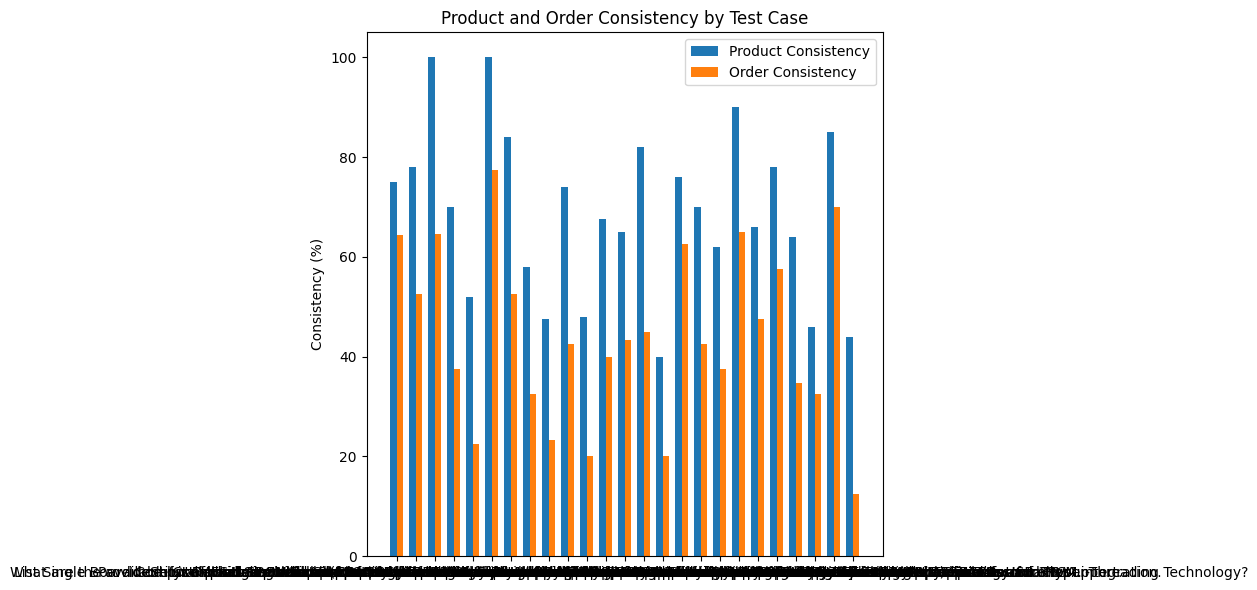

Overall Product Consistency: 68.88%
Overall Order Consistency: 44.01%


In [5]:
# Visualizations
def visualize_consistency(test_results: List[Dict[str, Any]]):
    names = [result["name"] for result in test_results]
    consistencies = [result["consistency"] for result in test_results]
    order_consistencies = [result["order_consistency"] for result in test_results]

    x = range(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x, consistencies, width, label="Product Consistency")
    ax.bar([i + width for i in x], order_consistencies, width, label="Order Consistency")

    ax.set_ylabel("Consistency (%)")
    ax.set_title("Product and Order Consistency by Test Case")
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(names)
    ax.legend()

    plt.tight_layout()
    plt.show()


visualize_consistency(test_results)

# Calculate overall consistency
overall_consistency = sum(result["consistency"] for result in test_results) / len(test_results)
overall_order_consistency = sum(result["order_consistency"] for result in test_results) / len(test_results)

print(f"Overall Product Consistency: {overall_consistency:.2f}%")
print(f"Overall Order Consistency: {overall_order_consistency:.2f}%")